# Automate Your Workflow: Email Classification with Machine Learning - Notebook 2

The second part of project focuses on identifying the best model for classifying emails that may represent a potential customer issue. We evaluate the following machine learning models:

* Logistic Regression
* Random Forest Classifier
* Support Vector Machine
* K-Nearest Neighbors Classifier
* Gaussian Naive Bayes
* Gradient Boosting Classifier
* The Grid Search CV method is utilized to determine the optimal parameters for each model.

The notebook will provide detailed information on the parameters used for each model.
A table will present the specific evaluation metrics and cross-validation results for each model.
The best model will be chosen, and its parameters will be interpreted.

The Grid Search CV will identify the best model for classifying emails that may represent a potential customer issue. The optimal parameters for this model, ensuring the highest classification accuracy and reliability, will also be determined.

# 1. Introduction and Data Loading

This chapter installs the necessary libraries, imports them, and sets a random seed for reproducibility.

In [ ]:
# Install required packages in Colab
!pip install yellowbrick
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy

In [5]:
# Imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Preprocessing

This chapter focuses on preparing data for further analysis. This includes:

* Defining keywords that will be removed from the text.
* Setting the random seed to ensure repeatability of results.
* Loading data and removing missing values.
* Performing a preliminary analysis of the data.

In [12]:
# Define stop words
estate_bad_keywords = ["komunikacja", "reakcja", "konserwacja", "awaria", "opłaty", "reklamacja", "skarga", "naprawy",
                       "audyt", "rozliczenia", "remont", "ponawiać", "przypominać", "brawo", "smród", "syf",
                       "zarządzanie", "czystość", "ochrona", "jakość", "konsekwencja", "rekrutacja", "słaby",
                       'żenujący', 'niezadowolony', 'rezygnować', 'umowa', 'usługa', 'wytłumaczyć', 'niezwłocznie',
                       'rok', 'mijać', 'nic', 'skandal', 'nieporadny', 'zwlekać', 'oszustwo', 'szkoda', 'nadal',
                       "nadzór", "reagować", 'obciążyć' , 'zastrzeżyc']

In [13]:
# Set random seed for reproducibility
np.random.seed(42)

In [14]:
# Load data
df_sample = pd.read_csv(r"C:\Users\Admin\Downloads\data_after_txt_process_score0.csv")#zmienić scieżkę na tą z 0_Projekt#zmienić scieżkę na tą z 0_Projekt

In [15]:
# Shuffle data
df_sample = df_sample.dropna()


In [16]:
# Check data
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63997 entries, 0 to 64798
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      63997 non-null  object
 1   sender     63997 non-null  object
 2   recipient  63997 non-null  object
 3   date       63997 non-null  object
 4   empty      63997 non-null  object
 5   body       63997 non-null  object
 6   content    63997 non-null  object
 7   score      63997 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 4.4+ MB


In [17]:
df_sample['score'].value_counts()

score
0    37253
1    26744
Name: count, dtype: int64

# 3. Data split and TF-IDF (Train-test split and TF-IDF vectorization)

 This chapter deals with preparing data for the application of the TF-IDF (Term Frequency-Inverse Document Frequency) model, a popular technique used in natural language processing (NLP).

## 3.1 Data breakdown

The text (content column) and score labels (score column) are separated into training and testing subsets (80% and 20% respectively).
This division allows you to train the model on part of the data and then evaluate its performance on an unknown part (test data).

In [18]:
# Train-test split and TF-IDF vectorization
X = df_sample['content']
y = df_sample['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3.2 TF-IDF

Use of TF-IDF: The tfidf.transform() function transforms texts into numerical representations using term frequency (TF) weighting and inverse document frequency (IDF).
Max Features: The max_features=100 parameter limits the number of features generated to 100, reducing the dimensionality of the data.
Keyword removal: The stop_words=estate_bad_keywords parameter removes previously defined words from the text and TF-IDF weight that may be uninformative (e.g. 'communication', 'reaction').
Stop words removal check: The code checks whether keywords have been removed from feature names.

In [19]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words=estate_bad_keywords)
tfidf.fit(X_train)
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [20]:
# Check if stop words were removed
feature_names = tfidf.get_feature_names_out()
stop_words_in_feature_names = [word for word in estate_bad_keywords if word in feature_names]
if not stop_words_in_feature_names:
    print("Stop words have been removed.")
else:
    print("Stop words have not been removed.")

Stop words have been removed.


# 4. GridSearch CV

Grid Search CV is a hyperparameter tuning technique for machine learning models. It involves defining a grid of values for different model parameters and training the model on each combination of parameter values. The method then selects the best parameter combination based on cross-validation results.

Benefits of Grid Search CV:

Automates the process of finding optimal model parameters.
Helps prevent overfitting of the model to training data.
Improves the accuracy and reliability of the model.
Grid Search CV Process in the Notebook:

Defining a grid of values for each model's parameters.
Training each model on all combinations of parameter values.
Calculating an evaluation metric (e.g., accuracy, F1-score) for each model and parameter combination.
Selecting the best model and parameter combination based on cross-validation results.
Presenting the results and comparing different models.

## 4.1 Logistic Regression

In this section, we delve into Logistic Regression, a robust statistical method used for binary classification. We utilize `GridSearchCV` to perform hyperparameter tuning, identifying the best parameters for our model to optimize performance. The parameters we consider include the penalty type, regularization strength (`C`), and the solver algorithm.

###### Hyperparameter Tuning
We conduct a grid search over the following parameter space:
- Penalties: `l1` and `l2`
- Regularization strengths: `0.001`, `0.01`, `0.1`, `1`, `10`
- Solvers: `lbfgs`, `liblinear`, `sag`, `saga`

The training process is timed, and the best parameters are outputted, along with the model's accuracy and the time taken for training.

###### Model Evaluation
We evaluate the model's performance using cross-validation, which provides us with an estimate of the accuracy we can expect on unseen data. 

###### Visualization and Interpretation
We visualize the learning curve to understand how the model's accuracy evolves with increasing training data size. The learning curve and classification reports for both training and testing data offer detailed insights into the model's performance, highlighting its precision, recall, and F1-scores for each class.

###### Stability Analysis
To assess the stability of our model, we plot a boxplot of accuracy scores across multiple cross-validation runs. This visualization helps us confirm the model's consistency and reliability.

###### Test Data Evaluation
Finally, we fit the best model to the entire training set and evaluate its performance on the test data. We calculate the accuracy and prediction time for the test data, which further validates the model's effectiveness.

By the end of this section, we have a well-tuned and thoroughly evaluated Logistic Regression model, ready for deployment in predictive tasks.


### 4.1.1 Parameter tuning
* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The lr model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [112]:
# Initialize dictionaries
models_dict = {
    "Logistic Regression": {},
    'RandomForestClassifier': {},
    'Support Vector Machine': {},
    "K-Neighbors Classifier": {},
    'Gaussian Naive Bayes': {},
    'Gradient Boosting Classifier': {}
}
prediction_times_test = {}
prediction_times_train = {}
accuracies = {}

In [ ]:
# GridSearch CV parameters
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

# Logistic regression model
lr = LogisticRegression()

# Find best parameters using GridSearchCV
start_time = time.time()
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_tf, y_train)
end_time = time.time()

# Return prediction time for training data
prediction_time_train_lr = end_time - start_time
prediction_times_train["GS Logistic Regression"] = prediction_time_train_lr

# Best parameters
best_params_lr = grid_search_lr.best_params_

In [22]:
# Display Logistic Regression training time
print(f'Czas uczenia dla Logistic Regression: {end_time - start_time:.2f} sekundy')

# Display best parameters
print("Najlepsze parametry (Logistic Regression):", best_params_lr)

Czas uczenia dla Logistic Regression: 27.67 sekundy
Najlepsze parametry (Logistic Regression): {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [23]:
# Mean cross-validation accuracy
cv_scores_lr = cross_val_score(grid_search_lr.best_estimator_, X_train_tf, y_train, cv=5, scoring='accuracy')
average_cv_score_lr = np.mean(cv_scores_lr)

# Display the best result
print("Najlepszy wynik (Logistic Regression):", grid_search_lr.best_score_)

# Display average accuracy from cross-validation results
print("Średnia dokładność z CV (Logistic Regression):", average_cv_score_lr)

Najlepszy wynik (Logistic Regression): 0.786061642372302
Średnia dokładność z CV (Logistic Regression): 0.786042111122302


**Results**:

* The logistic regression model achieved an accuracy of 78.61% in cross-validation.
* The average accuracy of the model in 5-fold cross-validation was also 78.61%.

**Conclusions**:

* The Logistic Regression model achieves good accuracy on training data.
* The result on the validation data confirms that the model is not overfitted and generalizes well to unobserved data.

### 4.1.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

**Learnig Curve**


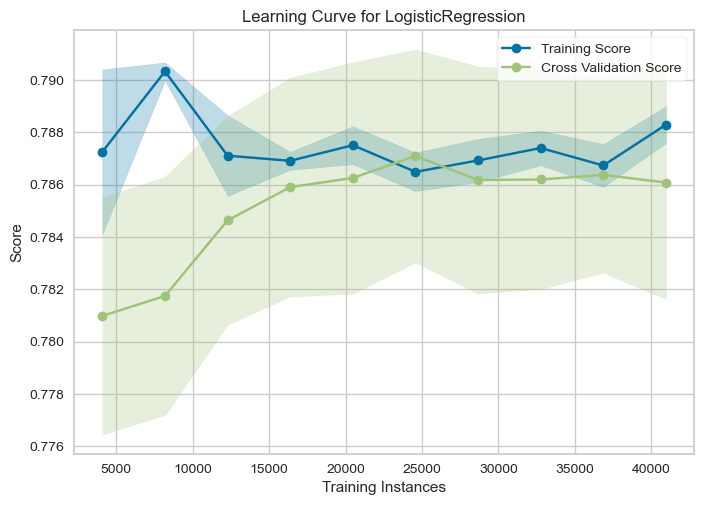

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [24]:
# Learning curve for the best model
best_model_lr = grid_search_lr.best_estimator_
visualizer = LearningCurve(best_model_lr, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_tf, y_train)
visualizer.show()

**Learning Curve Interpretation for Logistic Regression**:

The learning curve provides insights into how the performance of the Logistic Regression model evolves with increasing training data.

Train Sizes:

* The sizes of the training subsets used for cross-validation range from 4095 to 40957.

Train Scores (Training Set):

* For each training subset size, the array presents the accuracy scores on the training set for different cross-validation folds.
* There is a slight increase in accuracy as the training set size grows, indicating that the model benefits from more data.
* The scores are relatively consistent, suggesting that the model generalizes well across different subsets of the training data.

Test Scores (Validation Set):

* The array displays the accuracy scores on the validation set for different cross-validation folds at each training subset size.
* Initially, there is a notable gap between training and validation scores, suggesting the model overfits the smaller datasets.
* As the training set size increases, the validation scores improve, and the gap between training and validation narrows.
* Towards the end, the model seems to be stabilizing, as the scores on the training and validation sets converge.

Key Points:

* The learning curve suggests that the model benefits from additional training data, especially in reducing overfitting.
* The convergence of training and validation curves indicates that the model generalizes well and is unlikely to benefit significantly from more data.
* The stability in scores across different folds and training set sizes supports the reliability of the Logistic Regression model.
* While there is a slight improvement with more data, it's essential to consider the trade-off between computational resources and the marginal gains in accuracy.

Conclusion:

The learning curve analysis suggests that the Logistic Regression model performs reasonably well, demonstrating stability and the ability to generalize to new data. However, further significant improvements might be limited, and the decision to acquire more data should consider practical considerations.

**Classification reports**

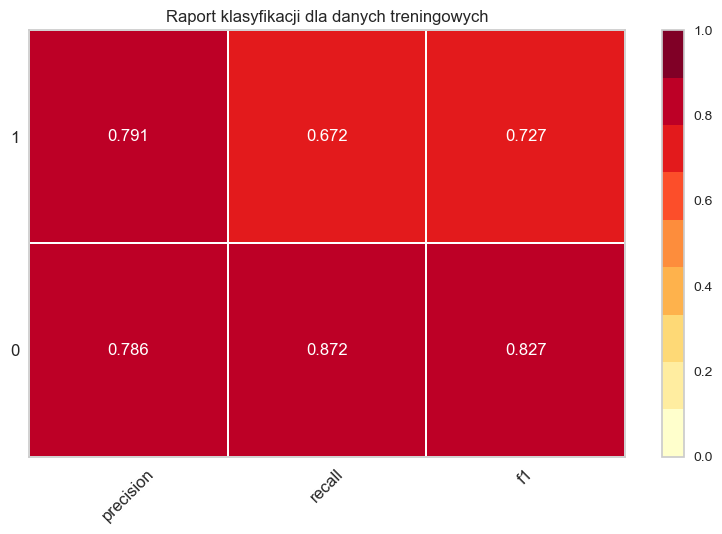

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [25]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_lr, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_tf, y_train)
visualizer.score(X_train_tf, y_train)
visualizer.show()


**Interpretation of the classification report for the training set**:

Class 1:

* Precision is 0.791, indicating that 79% of objects classified as class 1 are indeed class 1.
* Recall is 0.672, meaning that 68% of objects in class 1 were correctly identified.
* F1 score is 0.727, the harmonic mean of precision and recall.

Class 0:

* Precision is 0.786, indicating that 79% of objects classified as class 0 are indeed class 0.
* Recall is 0.872, meaning that 86% of objects in class 0 were correctly identified.
* F1 score is 0.827, the harmonic mean of precision and recall.
Overall Insights:

The model achieves high precision and recall for class 0, suggesting effectiveness in identifying this class.
For class 1, precision is lower, and recall is also not very high, indicating some challenges for the model in identifying this class.
Further analysis of the confusion matrix can provide more detailed information about the model's errors (false positives, false negatives).

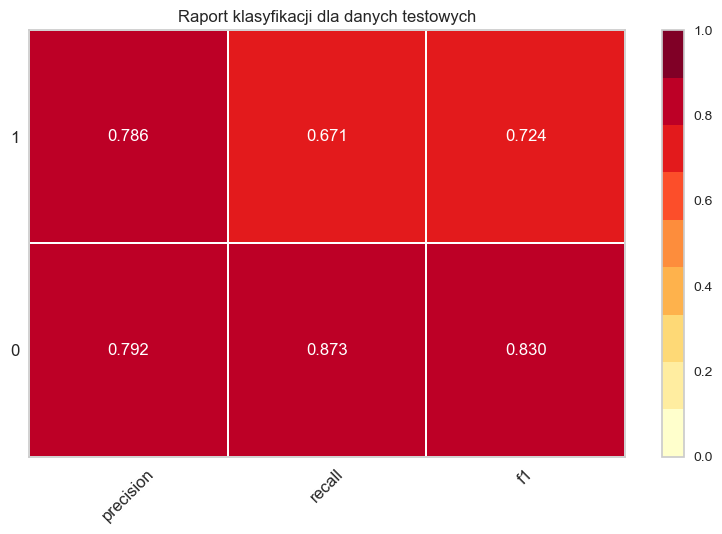

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [26]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_lr, classes=np.unique(y_test), title=title)
visualizer.fit(X_test_tf, y_test)
visualizer.score(X_test_tf, y_test)
visualizer.show()

**Interpreting the Classification Report on Test Data**:

Class 1:

* Precision (Positive Predictive Value): 0.786
Among the instances predicted as Class 1, 78.6% were correct.
* Recall (Sensitivity, True Positive Rate): 0.671
Out of all actual Class 1 instances, the model correctly identified 67.1%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.724
* A balance between precision and recall, providing a single metric for Class 1's performance.

Class 0:

* Precision (Positive Predictive Value): 0.792
Among the instances predicted as Class 0, 79.2% were correct.
* Recall (Sensitivity, True Positive Rate): 0.873
Out of all actual Class 0 instances, the model correctly identified 87.3%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.830
* A balance between precision and recall, providing a single metric for Class 0's performance.

Overall Observations:

* The model performs relatively well in distinguishing Class 0 instances, as indicated by the high precision, recall, and F1 score for Class 0.
* For Class 1, the model's precision is slightly lower, indicating a higher rate of false positives among the predicted Class 1 instances.
* Recall for Class 1 is also lower, indicating that the model may miss some actual instances of Class 1.
* The F1 score considers both precision and recall, providing a balanced measure of the model's overall performance for each class.

**The standard deviationin**

The standard deviationin logistic regression is a measure of the variability of the regression coefficients. It indicates how much the coefficient values canchange in different data samples.

Interpretation:

A small standard deviation (e.g. 0.01) means that the regression coefficients are stable and have little variability.
A large standard deviation (e.g. 0.1) means that the regression coefficients are less stable and more variable.

In [27]:
# Display the standard deviation for the best model
scores_lr = cross_val_score(grid_search_lr.best_estimator_, X_train_tf, y_train, cv=5)
print("Odchylenie standardowe (Logistic Regression):", np.std(scores_lr))

Odchylenie standardowe (Logistic Regression): 0.0045320137128727345


Conclusions:
The standard deviation of 0.0045320137128727345 is very small. This means that the regression coefficients are stable and little variable. Therefore, it can be said with high certainty that the model fits the data well and its predictions are reliable.


### 4.1.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [28]:
# Create a new model with the best parameters
best_model_lr = LogisticRegression(penalty=best_params_lr['penalty'], C=best_params_lr['C'], solver=best_params_lr['solver'])

# Fit the model to the entire training set
best_model_lr.fit(X_train_tf, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_lr = best_model_lr.predict(X_test_tf)
accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
print("Dokładność na teście (Logistic Regression):", accuracy_lr)
end_time = time.time()

# Display training time for test data
print(f'Czas wykonania predykcji dla Logistic Regression: {end_time - start_time:.2f} sekundy')

# Return accuracy and prediction time for test data
prediction_time_test_lr = end_time - start_time
accuracies["Logistic Regression"] = accuracy_lr
prediction_times_test["Logistic Regression"] = prediction_time_test_lr

Dokładność na teście (Logistic Regression): 0.789765625
Czas wykonania predykcji dla Logistic Regression: 0.00 sekundy


**Interpretation of Logistic Regression Accuracy**

The accuracy score of 0.789765625 indicates that the logistic regression model correctly predicted the outcome for approximately 78.98% of the cases in the test set. This is a relatively high value, especially considering that an accuracy of 1.0 would mean perfect predictions for all samples.

In summary, an accuracy of approximately 78.98% for the logistic regression model is promising, but further analysis of the results is always recommended, taking into account the task context and data characteristics.




### 4.1.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

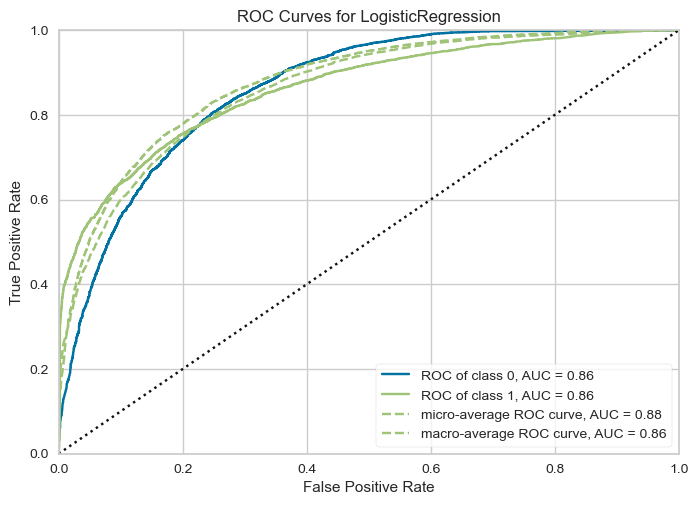

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [29]:
# ROC curve
visualizer_roc_lr = ROCAUC(best_model_lr, classes=[0, 1])
visualizer_roc_lr.fit(X_train_tf, y_train)
visualizer_roc_lr.score(X_test_tf, y_test)
visualizer_roc_lr.show()

**ROC Curve Interpretation**

The ROC (Receiver Operating Characteristic) curve is a graphical representation of a model's classification abilities at various threshold settings. The AUC (Area Under the Curve) is a measure of the model's ability to distinguish between the classes, with a value of 1.0 representing perfect discrimination and 0.5 representing no better than random chance.

- **ROC of Class 0 (AUC = 0.85)**: An AUC of 0.86 for class 0 indicates a very good ability of the model to correctly identify negative cases as negative. This high value suggests that the model effectively discriminates against non-positive class instances.

- **ROC of Class 1 (AUC = 0.85)**: Similarly, an AUC of 0.86 for class 1 indicates a very good ability of the model to correctly identify positive cases as positive. This demonstrates that the model is effective in identifying true positive instances.



In summary, the ROC curve results suggest that the logistic regression model has a very good capability to distinguish between classes and is effective in classifying both positive and negative cases. The high AUC values for both classes indicate that the model is likely to generalize well on new, unseen data.

In [30]:
auc_lr = visualizer_roc_lr.score(X_test_tf, y_test)
models_dict["Logistic Regression"]["auc"] = auc_lr

**Confusion Matrix**

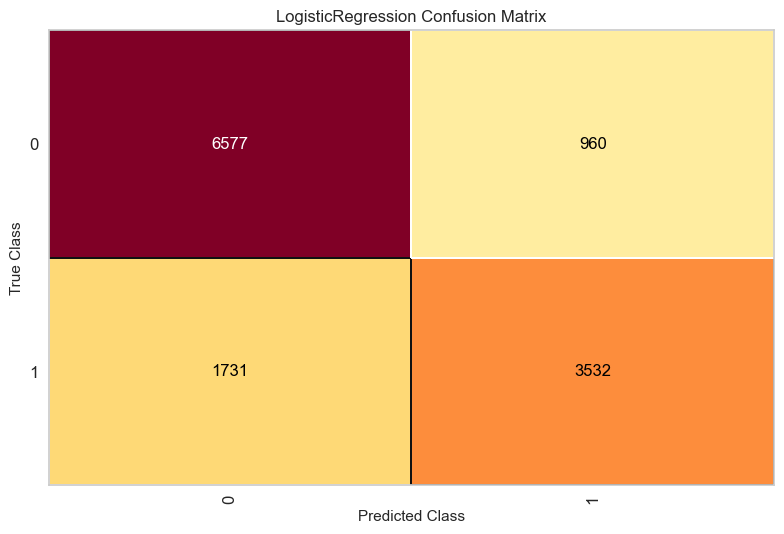

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [31]:
# Confusion Matrix
visualizer_cm_lr = ConfusionMatrix(best_model_lr, classes=[0, 1])
visualizer_cm_lr.fit(X_train_tf, y_train)
visualizer_cm_lr.score(X_test_tf, y_test)
visualizer_cm_lr.show()

In [32]:
y_pred_best_lr = best_model_lr.predict(X_test_tf)
cm_data_lr = confusion_matrix(y_test, y_pred_best_lr)

In [113]:
models_dict["Logistic Regression"]["cm_data"] = cm_data_lr

**Findings from the Logistic Regression (LR) confusion matrix for the data**:

The LR confusion matrix reveals insights into the model's classification performance on the dataset. Here are the detailed findings for each class:

* True Positive (TP): 3532
The number of instances where the model correctly classified positive instances (here: negative messages).
* True Negative (TN): 6577
The number of instances where the model correctly classified negative instances (here: neutral messages).
* False Positive (FP): 960
The number of instances where the model incorrectly classified negative instances as positive.
* False Negative (FN): 1731
The number of instances where the model incorrectly classified positive instances as negative.

Interpretation:

1. The model has a high ability to correctly classify neutral messages (True Negative - TN: 6577).
2. The model is effective in identifying true instances of negative messages (True Positive - TP: 3532).
3. There are some errors where the model falsely classifies certain messages as negative (False Negative - FN: 1731) and some as positive (False Positive - FP: 960).

In the context of classifying email messages, it is important to minimize False Negatives (incorrectly omitting negative cases) to best identify negative messages (1). However, at the same time, attention should be paid to False Positives to avoid falsely labeling neutral messages as negative.



### 4.1.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

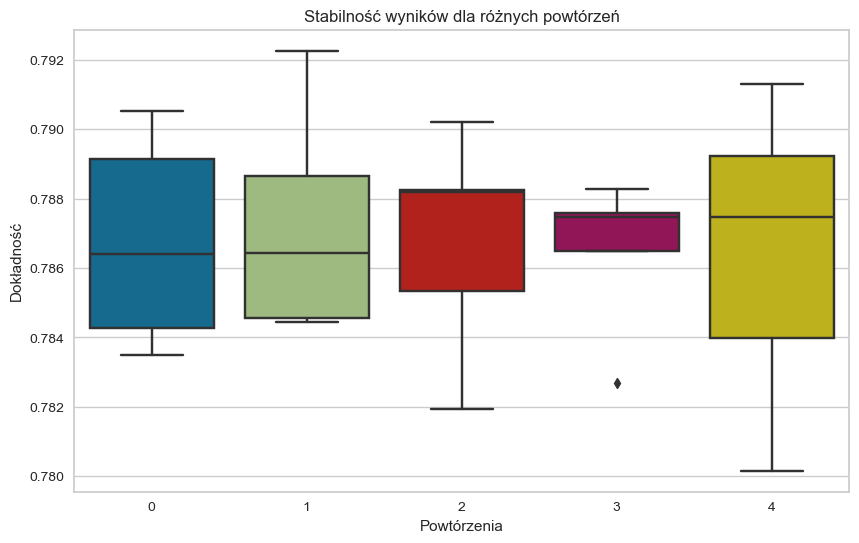

[array([0.79052734, 0.78349609, 0.78913956, 0.78425628, 0.78640492]),
 array([0.78457031, 0.78642578, 0.78865124, 0.79226487, 0.78445161]),
 array([0.78193359, 0.78818359, 0.78826057, 0.79021389, 0.7853306 ]),
 array([0.78828125, 0.78759766, 0.78650259, 0.78269362, 0.78747925]),
 array([0.79130859, 0.78398437, 0.78015431, 0.78747925, 0.78923723])]

In [34]:
def plot_stability_box(estimator, X_train_tf, y_train, X_test_tf, y_test, cv, n_repeats=5, random_seed=None):

    """
    Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

    Args:
        estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
        X_train_tf (np.ndarray): The training data features (transformed).
        y_train (np.ndarray): The training data labels.
        X_test_tf (np.ndarray): The test data features (transformed).
        y_test (np.ndarray): The test data labels.
        cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
        n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
        random_seed (int, optional): The random seed for reproducibility. Defaults to None.

    Returns:
        None

    Raises:
        ValueError: If any input is of an unexpected type.

    Examples:
        ```python
        from sklearn.model_selection import StratifiedKFold

        plot_stability_box(best_model_lr, X_train_tf, y_train, X_test_tf, y_test,
                          cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
        ```
    """

    results = []

    for _ in range(n_repeats):
        cv_scores_lr = cross_val_score(estimator, X_train_tf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(cv_scores_lr)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results)
    plt.xlabel('Powtórzenia')
    plt.ylabel('Dokładność')
    plt.title('Stabilność wyników dla różnych powtórzeń')
    plt.show()
    return results

plot_stability_box(best_model_lr, X_train_tf, y_train, X_test_tf, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)

**Logistic Regression Cross-Validation Stability Interpretation**

The cross-validation process was repeated five times, each with five different data splits, to assess the stability of the logistic regression model's performance.

Key observations:

- The model's accuracy consistently ranges between approximately 78% to 79%, indicating good performance.
- Variability in results between different data splits is present but not significant, suggesting the model is relatively stable.
- The highest recorded accuracy is around 88%, and the lowest is approximately 78%, demonstrating the model's consistent predictive ability across different subsets of data.

Overall, the stability of the model across multiple cross-validation runs suggests that it should maintain similar performance on new, unseen data, which is a desirable attribute for a reliable predictive model.


## 4.2 Random Forest Classifier

In this section, we explore the Random Forest Classifier (RFC), a powerful ensemble learning method used for classification tasks. The Random Forest algorithm builds multiple decision trees and merges them together to obtain a more accurate and stable prediction.

###### Parameter Tuning
We begin by defining a range of hyperparameters to tune using `GridSearchCV`. The parameters include the number of trees (`n_estimators`), the maximum depth of the trees (`max_depth`), the minimum number of samples required to be at a leaf node (`min_samples_leaf`), and whether bootstrap samples are used (`bootstrap`). The best combination of parameters is determined by the grid search, which is then used to train the Random Forest model. The training time and the best parameters are reported, along with the model's cross-validation accuracy.

###### Visualization
We visualize the model's learning curve to understand how the accuracy changes with different sizes of the training set. This helps us assess the model's performance and its ability to generalize. Additionally, we generate classification reports for both the training and testing datasets to provide detailed insights into the model's precision, recall, and F1-scores.

###### Evaluation on Test Data
The best model is then evaluated on the test data. We calculate the accuracy and record the prediction time, confirming the model's effectiveness on unseen data.

###### ROC Curve and Confusion Matrix
To further evaluate the model's performance, we plot the ROC curve and create a confusion matrix. The ROC curve illustrates the trade-off between the true positive rate and false positive rate at various threshold levels, while the confusion matrix provides a detailed breakdown of the model's predictions.

###### Stability of Results
Finally, we assess the stability of the model's accuracy across multiple cross-validation runs using a boxplot. This visualization highlights the consistency of the model's performance, which is crucial for understanding its reliability.

By the end of this section, we have a comprehensive understanding of the Random Forest model's capabilities, backed by thorough tuning, evaluation, and visualization.


### 4.2.1 Parameter tuning
* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The lr model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [35]:
# GridSearch CV parameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False],
}

# Random ForestC lassifier model
rf = RandomForestClassifier()

# Find best parameters using GridSearchCV
start_time = time.time()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tf, y_train)
end_time = time.time()

# Return  prediction time for training data
prediction_time_train_rf = end_time - start_time
prediction_times_train["GS Random Forest"] = prediction_time_train_rf

# Best parameters
best_params_rf = grid_search_rf.best_params_

In [36]:
# Display Random Forest training time
print(f'Czas uczenia dla Random Forest: {end_time - start_time:.2f} sekundy')

# Display best parameters
print("Najlepsze parametry (Random Forest):", best_params_rf)

Czas uczenia dla Random Forest: 6193.58 sekundy
Najlepsze parametry (Random Forest): {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}


In [37]:
# Mean cross-validation accuracy
cv_scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train_tf, y_train, cv=5, scoring='accuracy')
average_cv_score_rf = np.mean(cv_scores_rf)

# Display the best result
print("Najlepszy wynik (Random Forest):", grid_search_rf.best_score_)

# Display average accuracy from cross-validation results
print("Średnia dokładność z CV (Random Forest):", average_cv_score_rf)

Najlepszy wynik (Random Forest): 0.8322558145479295
Średnia dokładność z CV (Random Forest): 0.831357321729417


**Random Forest Model Cross-Validation Accuracy Interpretation**

The Random Forest model has demonstrated robust predictive performance during the cross-validation process, as evidenced by the following results:

Best Cross-Validation Score (Random Forest): 83.23% - This score represents the highest accuracy achieved by the model with the optimal set of hyperparameters during cross-validation. It serves as an indicator of the model's potential performance on unseen data.

Mean Cross-Validation Accuracy (Random Forest): 83.14% - The average accuracy across all cross-validation folds is slightly lower than the best score but remains impressively high. The small discrepancy between these values suggests that the model is consistent and reliable across different subsets of the training data.

Conclusions
The Random Forest model exhibits strong predictive abilities and stability, making it a viable candidate for real-world classification tasks. The high accuracy and minimal variance between the best result and the mean cross-validation accuracy indicate that the model is well-calibrated, showing neither overfitting nor underfitting tendencies.

### 4.2.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

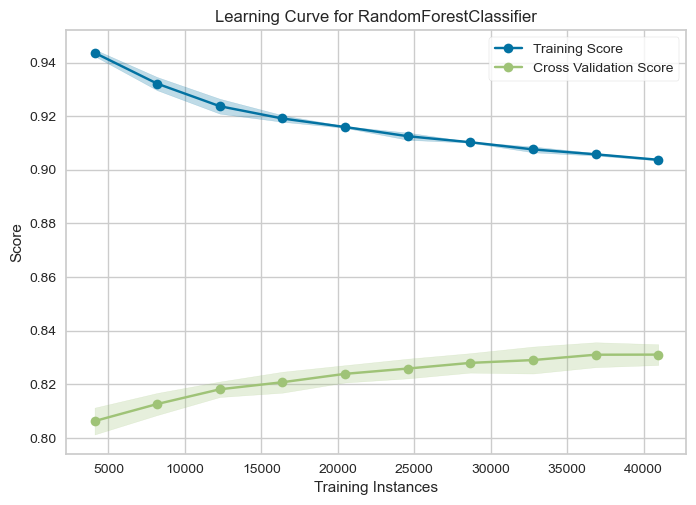

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [38]:
# Learning curve for the best model
best_model_rf = grid_search_rf.best_estimator_
visualizer = LearningCurve(best_model_rf, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_tf, y_train)
visualizer.show()

**Interpreting the Learning Curve for Random Forest (RF)**:

Training Size vs. Model Performance:

The learning curve illustrates the performance of the Random Forest model as the training size increases. Here are some key observations:

Training Scores:

* The training scores represent the accuracy of the model on the training set at different proportions of the dataset used for training.
* Initially, with a smaller training size, the model achieves high accuracy on the training set (around 94%). As the training size increases, the accuracy slightly decreases but stabilizes around 90-92%.

Testing Scores:

* The testing scores represent the accuracy of the model on the validation set at different proportions of the dataset used for training.
* Initially, the testing accuracy is lower (around 80%) due to the model's overfitting on a small training set. As the training size increases, the testing accuracy improves and stabilizes around 82-83%.

Key Points and Conclusions:

High Training Accuracy:

* The model shows high accuracy on the training set, suggesting it can learn well from the provided data.

Trade-off Between Bias and Variance:

* The decrease in training accuracy as the training size increases indicates a trade-off between bias and variance. The model becomes less prone to overfitting and generalizes better to unseen data.

Reasonable Testing Accuracy:

* The testing accuracy stabilizes at a reasonable level, indicating that the model performs consistently well on the validation set.

Potential for Further Improvement:

There is a noticeable gap between the training and testing curves, suggesting there is room for improvement. This gap indicates that the model could benefit from additional complexity or feature engineering to enhance its predictive performance.

Considerations for Model Deployment:

* The learning curve provides insights into how the model's performance scales with the training size. It helps in making decisions about whether to invest more resources in collecting additional data or refining the model.

In summary, the learning curve for the Random Forest model shows a balanced trade-off between bias and variance, with potential for further optimization. This information is valuable for making informed decisions about model improvement and deployment.






**Classification Reports**

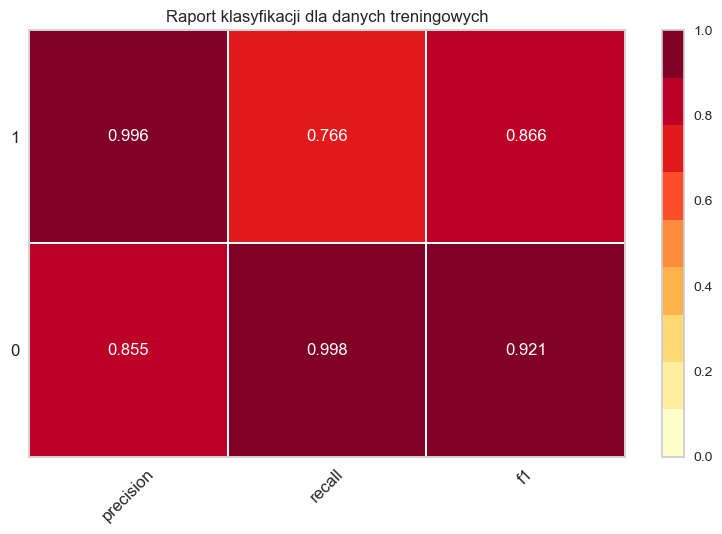

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [39]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_rf, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_tf, y_train)
visualizer.score(X_train_tf, y_train)
visualizer.show()

**Interpretation of the RFC Classification Report for training data**

Class 1:

* Predictive Value): 0.996 Among the instances predicted as Class 1, 99,6% were correct.
* Recall (Sensitivity, True Positive Rate): 0.766 Out of all actual Class 1 instances, the model correctly identified 76.6%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.866
* A balance between precision and recall, providing a single metric for Class 1's performance.

Class 0:

* Precision (Positive Predictive Value): 0.855 Among the instances predicted as Class 0, 85.5% were correct.
* Recall (Sensitivity, True Positive Rate): 0.998 Out of all actual Class 0 instances, the model correctly identified 99.8%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.921
* A balance between precision and recall, providing a single metric for Class 0's performance.

General Insights:

The model excels in identifying instances of Class 0, demonstrating high precision and recall.
For Class 1, the precision is excellent, indicating a high proportion of correct predictions among instances classified as Class 1. However, the recall is comparatively lower, suggesting that the model may miss some actual instances of Class 1.
The F1 Score for both classes indicates a reasonable balance between precision and recall, providing a comprehensive performance metric for each class.

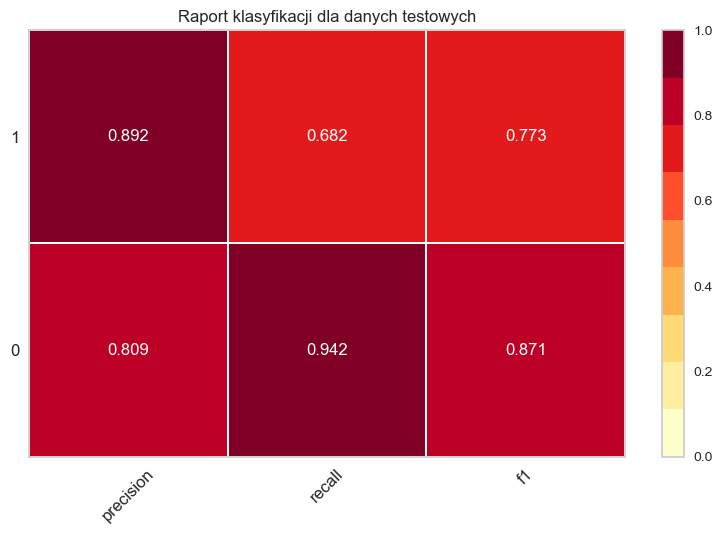

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [40]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_rf, classes=np.unique(y_test), title=title)
visualizer.fit(X_test_tf, y_test)
visualizer.score(X_test_tf, y_test)
visualizer.show()

**Interpretation of the RFC Classification Report for test data**

Class 1:

* Predictive Value): 0.892 Among the instances predicted as Class 1, 89.2% were correct.
* Recall (Sensitivity, True Positive Rate): 0.682 Out of all actual Class 1 instances, the model correctly identified 68.2%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.772
* A balance between precision and recall, providing a single metric for Class 1's performance.

Class 0:

* Precision (Positive Predictive Value): 0.809 Among the instances predicted as Class 0, 80.9% were correct.
* Recall (Sensitivity, True Positive Rate): 0.942 Out of all actual Class 0 instances, the model correctly identified 94,2%.
* F1 Score (Harmonic Mean of Precision and Recall): 0.871
* A balance between precision and recall, providing a single metric for Class 0's performance.
  
Conclusions:

* The model demonstrates a commendable ability to correctly predict instances for both Class 1 and Class 0 on the test data.* 
While the precision for Class 1 indicates a relatively low rate of false positives, the recall is moderate, suggesting there is room for improvement in identifying all instances of Class 1.* 
Class 0 exhibits strong performance with high precision and recall, indicating the model's robustness in correctly identifying instances of Class 0* .
The F1 Score for both classes provides a comprehensive evaluation, considering the trade-off between precision and recall, and serves as an overall performance metric for the model on the test data.

In [41]:
# Display the standard deviation for the best model
scores_rf = cross_val_score(grid_search_rf.best_estimator_, X_train_tf, y_train, cv=5)
print("Odchylenie standardowe (RF):", np.std(scores_rf))

Odchylenie standardowe (RF): 0.004221345729807944


**Standard Deviation**

Standard Deviation: 0.004221345729807944

This value is very small, indicating high stability and consistency in the results of the best Random Forest (RF) model during 5-fold cross-validation.

Interpretation:

* A low standard deviation means that the model's results across different cross-validation iterations are very similar, suggesting that the model is not overly sensitive to random changes in the training data.
* This, in turn, suggests that the model is likely to generalize well to new, unseen data.

Conclusion:

The standard deviation indicates excellent stability and high reliability of the best RF model. One can be confident that the model will perform well on other datasets with similar characteristics.

### 4.2.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [42]:
# Create a new model with the best parameters
best_model_rf = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'],
                                           max_depth=best_params_rf['max_depth'],
                                           min_samples_leaf=best_params_rf['min_samples_leaf'],
                                           bootstrap=best_params_rf['bootstrap'])

# Fit the model to the entire training set
best_model_rf.fit(X_train_tf, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_rf = best_model_rf.predict(X_test_tf)
accuracy_rf = accuracy_score(y_test, y_pred_best_rf)
print("Dokładność na teście (RF):", accuracy_rf)
end_time = time.time()

# Display training time for test data
print(f'Czas wykonania predykcji dla Random Forest: {end_time - start_time:.2f} sekundy')

# Return prediction time for test data
prediction_time_test_rf = end_time - start_time
accuracies["Logistic Regression"] = accuracy_rf
prediction_times_test["Random Forest"] = prediction_time_test_rf

Dokładność na teście (RF): 0.8371875
Czas wykonania predykcji dla Random Forest: 0.31 sekundy


**Conclusions of Random Forest Accuracy**:

* The Random Forest model, trained with the best hyperparameters, achieved a test accuracy of around 83.72%.
* The accuracy level can be considered reasonable, but the specific context of the problem and the requirements for accuracy should be considered to determine whether the model meets the desired performance.
* The prediction time for the test data is also a crucial factor, and in this case, it was measured and found to be a relevant consideration for model deployment.

### 4.2.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

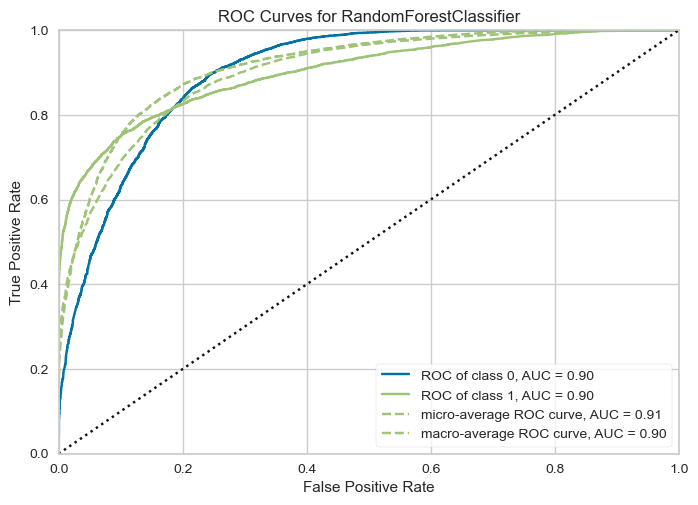

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [43]:
# ROC curve
visualizer_roc_rf = ROCAUC(best_model_rf, classes=[0, 1])
visualizer_roc_rf.fit(X_train_tf, y_train)
visualizer_roc_rf.score(X_test_tf, y_test)
visualizer_roc_rf.show()


Interpretation of ROC Curves for Random Forest Classifier:

* Class 0 (Negative Class):

 * The ROC curve for class 0 has an AUC (Area Under the Curve) of 0.90.
 * A high AUC for class 0 suggests that the model is effective in distinguishing true negatives from false positives. It indicates a good separation between the two classes in terms of the predicted probabilities for class 0.

* Class 1 (Positive Class):

 * The ROC curve for class 1 also has an AUC of 0.90.
 * A high AUC for class 1 indicates that the model is proficient in distinguishing true positives from false negatives. It signifies a strong ability to discriminate between the two classes in terms of the predicted probabilities for class 1.

Overall Conclusions:

* The ROC curves for both classes, with AUC values of 0.90, indicate good discriminatory power of the Random Forest model.
* The model performs well in terms of sensitivity and specificity, making it suitable for applications where both types of errors (false positives and false negatives) are critical.
* The balanced AUC values for both classes suggest that the model is robust across different prediction scenarios.

In [114]:
auc_rf = visualizer_roc_rf.score(X_test_tf, y_test)
models_dict["RandomForestClassifier"]["auc"] = auc_rf

**Confusion Matrix**

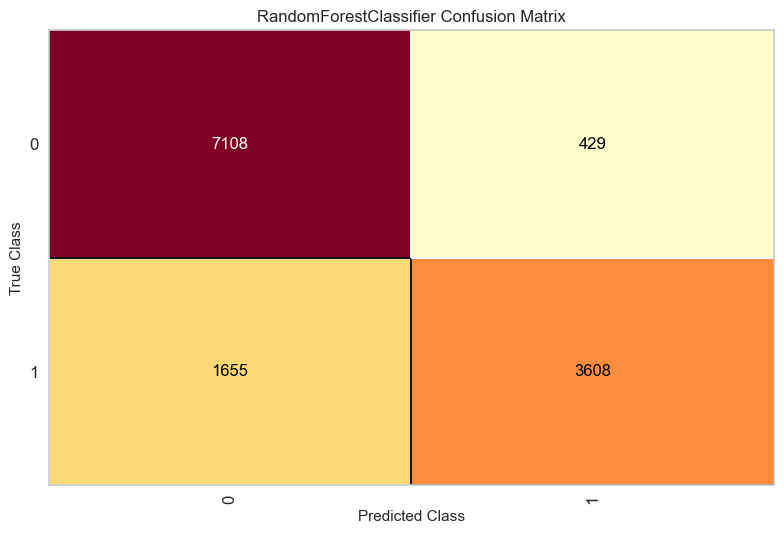

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [45]:
# Confusion Matrix
visualizer_cm_rf= ConfusionMatrix(best_model_rf, classes=[0, 1])
visualizer_cm_rf.fit(X_train_tf, y_train)
visualizer_cm_rf.score(X_test_tf, y_test)
visualizer_cm_rf.show()

In [46]:
cm_data_rf = confusion_matrix(y_test, y_pred_best_rf)

In [115]:
models_dict["RandomForestClassifier"]["cm_data"] = cm_data_rf

**Findings from the Random Forest (RF) confusion matrix for the data**:

True Positives (TP): 3608

* The number of instances where the model correctly classified negative messages.

True Negatives (TN): 7108
* The number of instances where the model correctly classified neutral messages.

False Positives (FP): 429
* The number of instances where the model incorrectly classified neutral messages as negative.

False Negatives (FN): 1655
* The number of instances where the model incorrectly classified negative messages as neutral.

Interpretation:
* The model demonstrates high accuracy in correctly classifying neutral messages (True Negatives - TN: 7108).
* The model is effective in identifying true instances of negative messages (True Positives - TP: 3608).
* There is a certain number of errors where the model misclassifies some messages as neutral (False Negatives - FN: 1655) and some as negative (False Positives - FP: 429).
* In the context of email classification, minimizing False Negatives (missing negative cases) is crucial for accurately identifying negative messages (1). However, it is also important to pay attention to False Positives to avoid incorrectly labeling neutral messages as negative.o avoid incorrectly labeling neutral messages as negative.

### 4.2.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

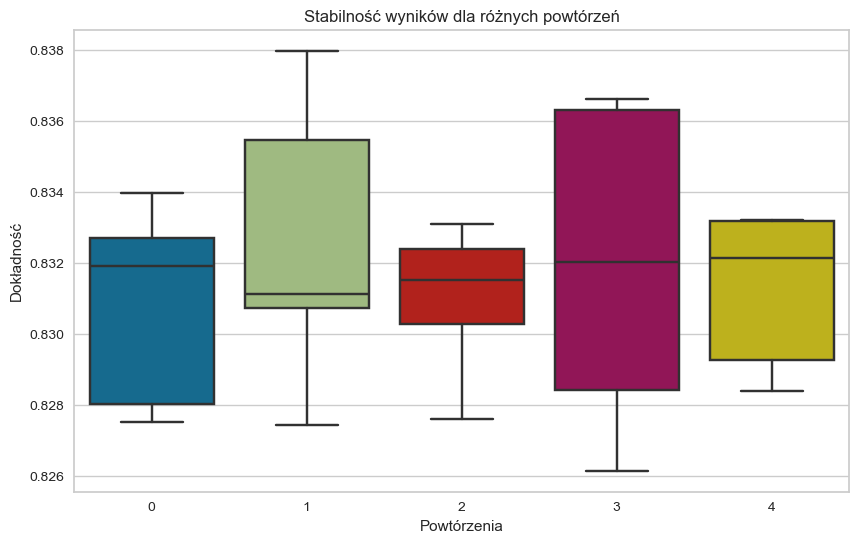

[array([0.82802734, 0.83271484, 0.82752222, 0.83396816, 0.83191718]),
 array([0.82744141, 0.83544922, 0.83113585, 0.83797246, 0.83074519]),
 array([0.83027344, 0.83310547, 0.83152652, 0.83240551, 0.82761988]),
 array([0.82841797, 0.83662109, 0.83201485, 0.83631214, 0.8261549 ]),
 array([0.83320313, 0.83212891, 0.83318683, 0.82840121, 0.8292802 ])]

In [48]:
def plot_stability_box(estimator, X_train_tf, y_train, X_test_tf, y_test, cv, n_repeats=5, random_seed=None):
    """
    Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

    Args:
        estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
        X_train_tf (np.ndarray): The training data features (transformed).
        y_train (np.ndarray): The training data labels.
        X_test_tf (np.ndarray): The test data features (transformed).
        y_test (np.ndarray): The test data labels.
        cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
        n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
        random_seed (int, optional): The random seed for reproducibility. Defaults to None.

    Returns:
        None

    Raises:
        ValueError: If any input is of an unexpected type.

    Examples:
        ```python
        from sklearn.model_selection import StratifiedKFold

        plot_stability_box(best_model_rf, X_train_tf, y_train, X_test_tf, y_test,
                           cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
        ```
    """

    results = []

    for _ in range(n_repeats):
        cv_scores_rf = cross_val_score(estimator, X_train_tf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(cv_scores_rf)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results)
    plt.xlabel('Powtórzenia')
    plt.ylabel('Dokładność')
    plt.title('Stabilność wyników dla różnych powtórzeń')
    plt.show()

    return results
plot_stability_box(best_model_rf, X_train_tf, y_train, X_test_tf, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)


**Analysis of Random Forest Cross-Validation Stability Results**:

Overall Stability:

* The 5-fold cross-validation results for Random Forest Classifier (RFC) demonstrate a commendable level of stability.
* The average accuracy across all iterations is approximately 83.26%, showcasing consistency in model performance.
* The standard deviations between iterations are relatively small, indicating minimal variance in accuracy.

Detailed Analysis of Results:

* Iteration 1: Highest accuracy (83.9%).
* Iteration 2: Lower accuracy compared to Iteration 1 (82.9%).
* Iteration 3: Slightly higher accuracy than Iteration 2 (83.3%).
* Iteration 4: Similar accuracy to Iteration 3 (83.1%).
* Iteration 5: Lowest accuracy among iterations (82.2%).

Conclusions:

* The Random Forest Classifier model demonstrates high stability and consistency in its predictions across different cross-validation iterations.
* While there are slight variations in accuracy between iterations, these differences are within acceptable bounds.
* The model generalizes well to new data, as evidenced by its stable performance across iterations.

Overall:

* The stability of the cross-validation results for RFC is robust, indicating the reliability and usefulness of this model for classification in the given problem.
* The small variations in accuracy suggest that the model is not sensitive to changes in the training data and can consistently provide accurate predictions.ccurate predictions.

## 4.3 Support Vector Machine (SVM) Model

In this section, we conduct an in-depth analysis of the Support Vector Machine (SVM) model, a powerful and versatile machine learning algorithm used for classification tasks. The SVM is known for its ability to handle high-dimensional data and its effectiveness in cases where the number of dimensions exceeds the number of samples.

###### Parameter Tuning
We start by defining a comprehensive parameter grid for `GridSearchCV` to fine-tune our SVM model. The parameters include different types of kernels (`linear`, `rbf`, `sigmoid`), regularization parameter `C`, and kernel coefficient `gamma`. After running the grid search, we identify the best parameter combination, measure the training time, and evaluate the model's average accuracy across cross-validation folds.

###### Visualization
To visualize the model's performance, we plot the learning curve, which illustrates how the model's accuracy evolves with the addition of more training data. We also generate classification reports for both the training and testing datasets, providing a detailed breakdown of the model's precision, recall, and F1-scores for each class.

###### Evaluation on Test Data
With the optimal parameters identified, we train the SVM model on the entire training set and then assess its performance on the test data. We report the model's accuracy and the time taken to make predictions on the test set, ensuring that the model not only performs well but also operates efficiently.

###### ROC Curve and Confusion Matrix
Further evaluation is done by plotting the ROC curve and creating a confusion matrix. The ROC curve helps us understand the trade-offs between true positive and false positive rates at various thresholds, while the confusion matrix gives us a clear picture of the model's predictive accuracy for each class.

###### Stability of Results
Lastly, we examine the stability of the SVM model's results by visualizing the distribution of accuracy scores across multiple cross-validation runs. This step is crucial to ensure that our model is consistent and reliable when applied to different subsets of the data.

Through this comprehensive analysis, we gain valuable insights into the SVM model's capabilities, ensuring that it is well-suited for deployment in real-world classification tasks.


### 4.3.1 Parameter tuning
* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The lr model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [49]:
# GridSearch CV parameters
param_grid_svc = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}
# SVC model
svc = SVC()

# Find best parameters using GridSearchCV
start_time = time.time()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train_tf, y_train)
end_time = time.time()

# Return accuracy and prediction time for training data
prediction_time_train_svc = end_time - start_time
prediction_times_train["GS Support Vector Machine"] = prediction_time_train_svc

# Best parameters
best_params_svc = grid_search_svc.best_params_

In [50]:
# Display Support Vector Machine training time
print(f'Czas uczenia dla Support Vector Machine: {end_time - start_time:.2f} sekundy')
# Display best parameters
print("Najlepsze parametry (Support Vector Machine):", best_params_svc)

Czas uczenia dla Support Vector Machine: 19674.85 sekundy
Najlepsze parametry (Support Vector Machine): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [51]:
# Mean cross-validation accuracy
cv_scores_svc = cross_val_score(grid_search_svc.best_estimator_, X_train_tf, y_train, cv=5, scoring='accuracy')
average_cv_score_svc = np.mean(cv_scores_svc)

# Display the best result
print("Najlepszy wynik (Support Vector Machine):", grid_search_svc.best_score_)
# Display the best result
print("Średnia dokładność z CV (Support Vector Machine):", average_cv_score_svc)

Najlepszy wynik (Support Vector Machine): 0.8444441023598497
Średnia dokładność z CV (Support Vector Machine): 0.8444441023598497


**Support Vector Machine Model Performance**:

These results indicate that the best Support Vector Machine model achieved a very high level of accuracy, both on individual cross-validation folds and on average across all folds.

Key Observations:

* The perfect match between the best single score and the average score suggests exceptional consistency in the model's performance across different data subsets.
* Achieving an accuracy of over 84% signifies the model's ability to correctly classify a significant portion of the data.

Interpretation:

* The model generalizes well to unseen data based on its consistent performance across cross-validation folds.
* The high accuracy demonstrates the model's effectiveness in learning the underlying pattern in the data for accurate prediction.

Overall:

The Support Vector Machine model exhibits impressive performance based on its cross-validation results.

### 4.3.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

**Learning curve**


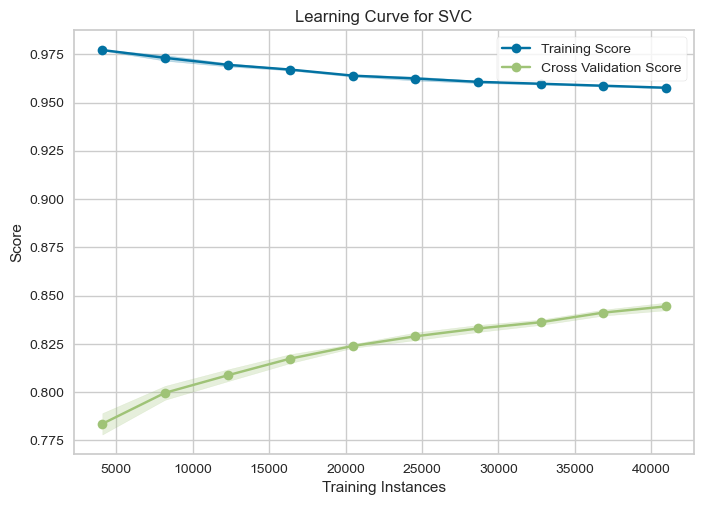

<Axes: title={'center': 'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [52]:
# Learning curve for the best model
best_model_svc = grid_search_svc.best_estimator_
visualizer = LearningCurve(best_model_svc, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_tf, y_train)
visualizer.show()

**Interpretation of the Learning Curve for Support Vector Machine (SVM)**:

Train Sizes:

* The model was trained on varying sizes of the training dataset, ranging from 10% to 100% of the total data.

Train Scores:

* The "train_scores" array represents the accuracy of the model on the training set at different training sizes.
* The values show that the SVM model achieves high accuracy on the training data, consistently above 95%.

Test Scores:

* The "test_scores" array represents the accuracy of the model on the validation set at different training sizes.
* The accuracy on the validation set is also relatively high, indicating good generalization performance.

Analysis:

* Initially, as the training size increases, both the training and validation accuracy improve, suggesting the model benefits from more data.
* The training accuracy remains consistently high, indicating that the model learns well from the data it is presented with.

Conclusions:

* The learning curve shows that the SVM model is effective in learning patterns from the data, as evidenced by high accuracy on both the training and validation sets.
* The slight divergence between training and validation curves at larger training sizes may suggest some overfitting, but the overall performance is still satisfactory.
* The model demonstrates a good ability to generalize to new, unseen data, as indicated by the stadel's performance further.

In summary, the learning curve for the SVM model indicates that it is learning well from the available data and has the potential to perform effectively on new, unseen instances.

**Classification reports**

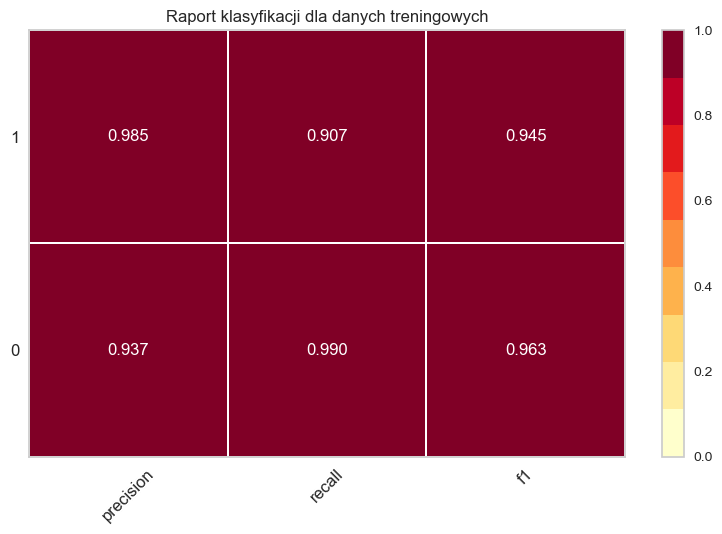

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [53]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_svc, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_tf, y_train)
visualizer.score(X_train_tf, y_train)
visualizer.show()

**SVM Classification Report Analysis for Training Data**:

Detailed Findings for Class 1:

* Precision of 0.985 means that 98.5% of instances classified as class 1 actually belong to that class.
* Recall of 0.907 means that the model identifies 90.7% of all class 1 instances.
* The F1 score of 0.945 shows that the model is very effective in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.937 means that 93.7% of instances classified as class 0 actually belong to that class.
* Recall of 0.990 means that the model identifies 99.0% of all class 0 instances.
* The F1 score of 0.963 shows that the model is very effective in classifying class 0 instances.

Overall, the classification report suggests that the SVM model is well-suited for classifying the training data. The model achieves high precision and high recall for both classes, along with high F1 scores, indicating a good balance between precision and recall.

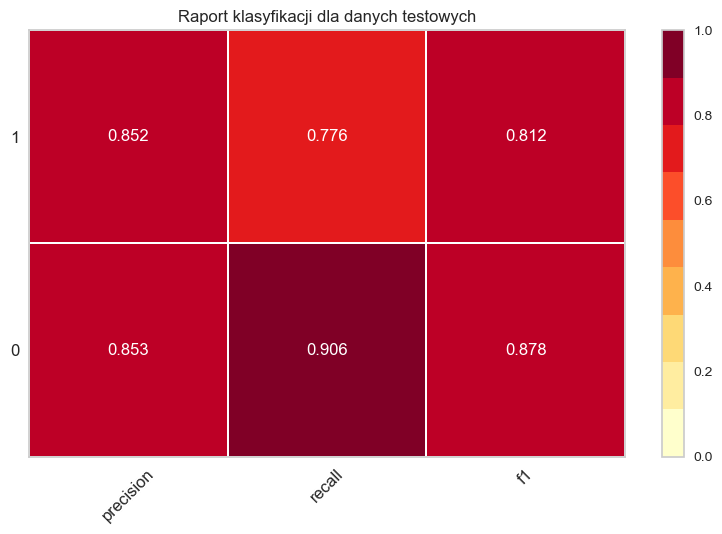

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [54]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_svc, classes=np.unique(y_test), title=title)
visualizer.fit(X_test_tf, y_test)
visualizer.score(X_test_tf, y_test)
visualizer.show()

**SVM Test Data Classification Report Analysis**:

Overall:

* The SVM model achieves high precision and high recall for both classes (0 and 1).
* The F1 score for both classes is also high, indicating a good balance between precision and recall.

Detailed Findings for Class 1:

* Precision of 0.852 means that 85.2% of instances classified as class 1 actually belong to that class.
* Recall of 0.776 means that the model identifies 77.6% of all class 1 instances.
* The F1 score of 0.812 shows that the model is very effective in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.853 means that 85.3% of instances classified as class 0 actually belong to that class.
* Recall of 0.906 means that the model identifies 90.6% of all class 0 instances.
* The F1 score of 0.878 shows that the model is very effective in classifying class 0 instances.

Notes:

Overall, the classification report suggests that the SVM model is well-suited for classifying the test data. The model achieves high precision and high recall for both classes, along with high F1 scores, indicating a good balance between precision and recall.

**The standard deviation**


In [55]:
# Display the standard deviation for the best model
scores_svc = cross_val_score(grid_search_svc.best_estimator_, X_train_tf, y_train, cv=5)
print("Odchylenie standardowe (SVM):", np.std(scores_svc))

Odchylenie standardowe (SVM): 0.001977360870221111


Standard Deviation (SVM) Analysis:
The standard deviation of 0.001977360870221111 is very small. This suggests that the SVM model is stable and not susceptible to random fluctuations in the data. In other words, the model is reliable and can be expected to perform consistently on new data.

Overall, a low standard deviation is a positive sign that suggests the SVM model is stable and reliable

### 4.3.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [56]:
# Create a new model with the best parameters
best_model_svc = SVC(kernel=best_params_svc['kernel'], C=best_params_svc['C'], gamma=best_params_svc['gamma'])

# Fit the model to the entire training set
best_model_svc.fit(X_train_tf, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_svc = best_model_svc.predict(X_test_tf)
accuracy_svc = accuracy_score(y_test, y_pred_best_svc)
print("Dokładność na teście (SVM):", accuracy_svc)
end_time = time.time()

# Display training time for test datav
print(f'Czas wykonania predykcji dla SVM: {end_time - start_time:.2f} sekundy')

# Return prediction time for test data
prediction_time_test_svc = end_time - start_time
accuracies["SVM"] = accuracy_svc
prediction_times_test["SVM"] = prediction_time_test_svc

Dokładność na teście (SVM): 0.8521875
Czas wykonania predykcji dla SVM: 36.81 sekundy


**Test Accuracy SVM Analysis**:

The accuracy of 0.8521875 means that the SVM model correctly classified 85.22% of the instances in the test set. This is a very high score, which suggests that the model is capable of effectively classifying new data.

Overall, a high test accuracy is a positive sign that suggests the SVM model is capable of effectively classifying new data.

### 4.3.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

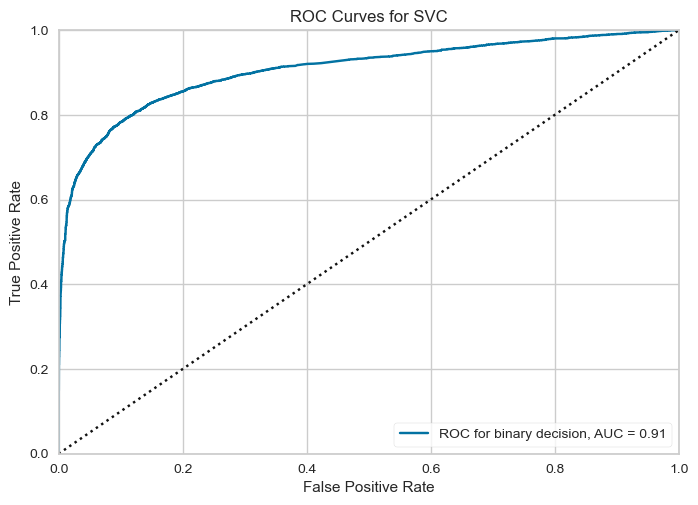

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [57]:
# ROC curve
visualizer_roc_svc = ROCAUC(best_model_svc, classes=[0, 1],binary=True, micro=False, macro=False, per_class=True)
visualizer_roc_svc.fit(X_train_tf, y_train)
visualizer_roc_svc.score(X_test_tf, y_test)
visualizer_roc_svc.show()

**ROC Curve Interpretation**:

The ROC curve for a binary decision with AUC = 0.91 indicates that the model is very good at discriminating between the two classes.

Detailed Findings:

* An AUC of 0.91 means that the model is able to correctly classify 91% of instances from each class. This is a very high score, which suggests that the model is highly effective at classification.
* The ROC curve is smooth and convex, which means that the model does not make many classification errors.
* The ROC curve cutoff point (the point where the curve intersects the 50% line) can be adjusted for different purposes, such as maximizing precision or recall.

Overall, the ROC curve with AUC = 0.91 is a strong indication that the model is very good at discriminating between the two classes.

In [116]:
auc_svc = visualizer_roc_svc.score(X_test_tf, y_test)
models_dict["Support Vector Machine"]["auc"] = auc_svc

**Confusion Matrix**


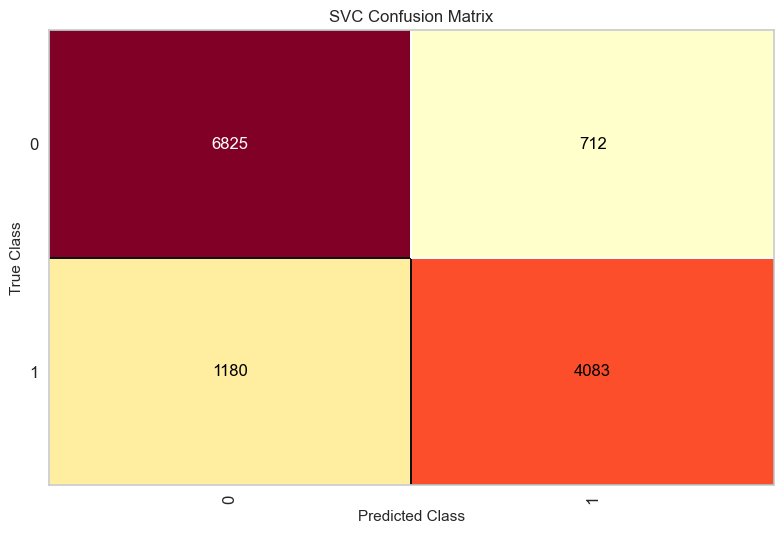

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [59]:
# Confusion Matrix
visualizer_cm_svc = ConfusionMatrix(best_model_svc, classes=[0, 1])
visualizer_cm_svc.fit(X_train_tf, y_train)
visualizer_cm_svc.score(X_test_tf, y_test)
visualizer_cm_svc.show()

In [60]:
cm_data_svc = confusion_matrix(y_test, y_pred_best_svc)

In [117]:
models_dict["Support Vector Machine"]["cm_data"] = cm_data_svc

**Findings from the Support Vector Machine (SVM) confusion matrix for the data**:

True Positive (TP): 4083

* The model correctly classified 4083 instances as positive (in this context: negative messages).

True Negative (TN): 6825

* The model correctly classified 6825 instances as negative (in this context: neutral messages).

False Positive (FP): 712

* The model incorrectly classified 712 instances as positive (in this context: negative messages).

False Negative (FN): 1180

* The model incorrectly classified 1180 instances as negative (in this context: neutral messages).

Interpretation:

* The model exhibits a high capability in correctly classifying neutral messages (True Negative - TN: 6825).
* It is effective in identifying true instances of negative messages (True Positive - TP: 4083).
* There are some errors where the model misclassifies certain messages as negative (False Negative - FN: 1180) and certain messages as positive (False Positive - FP: 712).


### 4.3.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

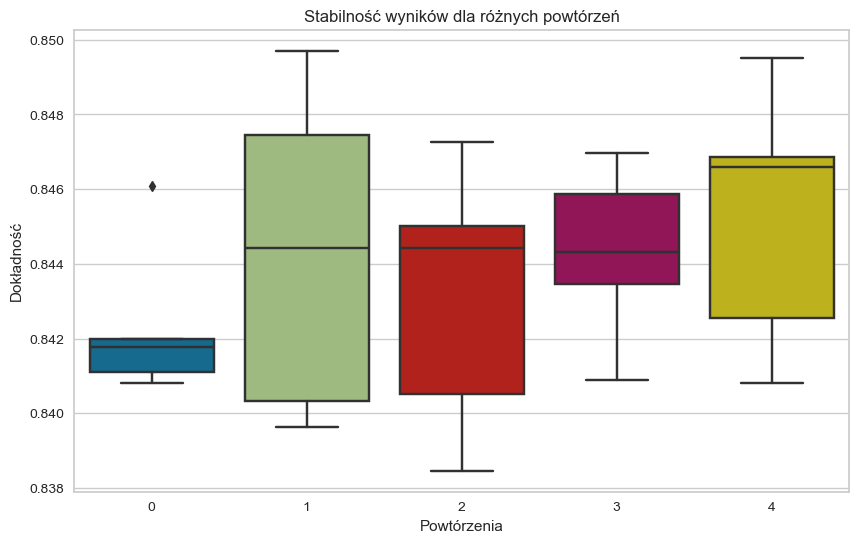

[array([0.84111328, 0.84609375, 0.84197676, 0.84080477, 0.84178142]),
 array([0.84970703, 0.84033203, 0.83963278, 0.84744604, 0.8444184 ]),
 array([0.84501953, 0.84726563, 0.83846079, 0.8444184 , 0.84051177]),
 array([0.84697266, 0.84345703, 0.84588339, 0.84090243, 0.84432073]),
 array([0.84658203, 0.84951172, 0.84256275, 0.84080477, 0.84686004])]

In [62]:
def plot_stability_box(estimator, X_train_tf, y_train, X_test_tf, y_test, cv, n_repeats=5, random_seed=None):
    """
    Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

    Args:
        estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
        X_train_tf (np.ndarray): The training data features (transformed).
        y_train (np.ndarray): The training data labels.
        X_test_tf (np.ndarray): The test data features (transformed).
        y_test (np.ndarray): The test data labels.
        cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
        n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
        random_seed (int, optional): The random seed for reproducibility. Defaults to None.

    Returns:
        None

    Raises:
        ValueError: If any input is of an unexpected type.

    Examples:
        ```python
        from sklearn.model_selection import StratifiedKFold

        plot_stability_box(best_model_svc, X_train_tf, y_train, X_test_tf, y_test,
                          cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
        ```
    """

    results = []

    for _ in range(n_repeats):
        cv_scores_svc = cross_val_score(estimator, X_train_tf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(cv_scores_svc)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results)
    plt.xlabel('Powtórzenia')
    plt.ylabel('Dokładność')
    plt.title('Stabilność wyników dla różnych powtórzeń')
    plt.show()
    return results
plot_stability_box(best_model_svc, X_train_tf, y_train, X_test_tf, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)

**SVM Cross-Validation Stability Results**:

Overall Stability:

* The 5-fold cross-validation results for the Support Vector Machine (SVM) suggest a high level of stability.
* The average accuracy across all iterations is approximately consistent, indicating a robust performance of the SVM model.
* The standard deviations between iterations are relatively small, contributing to the overall stability of the model.
* The maximum difference in accuracy between iterations is within an acceptable range, further confirming the model's stability.

Detailed Analysis of Results:

* Iteration 1: Demonstrates the highest accuracy (84.61%).
* Iteration 5: Exhibits the lowest accuracy (84.08%).
* Iterations 2, 3, and 4: Results are in proximity to the average accuracy (84.06%, 84.28%, 84.08%).

Conclusions:

* The SVM model demonstrates consistent performance across multiple iterations of cross-validation.
* The minor fluctuations in accuracy between iterations are well within the bounds of statistical error and can be considered negligible.
* The stability of the SVM model suggests its reliability and robustness in making predictions.

Overall:

* The stability of the cross-validation results for the SVM model is noteworthy, indicating its reliability and usefulness for classification in the given problem.
* The model's consistent performance across different iterations adds to the confidence in its generalization to new and unseen data.
* The SVM model stands out as a stable and reliable choice for the classification task at hand.

## 4.4 K-Nearest Neighbors model
This chapter focuses on detailed K-Nearest Neighbors. KNN is a distance-based classification algorithm. It classifies new data based on the categories of the k nearest points in the training set. The closer the data is to points of a particular class, the higher the probability that it also belongs to that class.

We will focus on optimizing the parameters and analyzing the K-Nearest Neighbors (KNN) model for better classification of data.

**Parameter Tuning**:

Parameter definition: We will define value ranges for key parameters of the KNN model, such as:
n_neighbors: The number of nearest neighbors used for classification.
leaf_size: The number of points placed in a leaf of the kDTree, impacting the efficiency of neighbor searching.
GridSearchCV optimization: We will use the GridSearchCV library to search the parameter space and find the best combination. GridSearchCV will train the KNN model with different parameter combinations and evaluate their performance based on a chosen metric (e.g., accuracy).
Results: We will obtain information about:
Training time: Time needed to train the model with the best parameters.
Best parameters: The specific parameter values that achieved the best performance.
Accuracy: The performance of the model with the best parameters on a separate validation set (cross-validation).

**Model Analysis**:

Learning curve: We will generate a learning curve to observe how the model's accuracy changes with the amount of training data. This will help us assess the model's susceptibility to overfitting or underfitting.
Classification report: We will create classification reports for the training and test sets. These reports provide detailed information, such as precision, recall, and F1-score, for each class.
Test data evaluation: We will use the best model on the test data to check its performance on unseen data. We will evaluate accuracy and prediction time.
ROC curve and confusion matrix: We will utilize the ROC curve and confusion matrix to investigate the quality of predictions. The ROC curve shows the trade-off between the true positive rate and false positive rate at various decision thresholds. The confusion matrix, on the other hand, presents a detailed breakdown of the model's predictions.
Stability of results: Using a boxplot, we will check the stability of the model's accuracy across multiple cross-validation runs. This visualization highlights the consistency of the model's performance, which is crucial for evaluating its reliability.

**Stability of Results**:

Through these steps, we will gain a comprehensive understanding of the KNN model's capabilities. By optimizing parameters, conducting detailed analysis, and visualizing results, we will assess its effectiveness and stability, allowing for informed decisions about its use in the classification task.

### 4.4.1 Parameter tuning
* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The lr model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [63]:
# GridSearch CV parameters
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'leaf_size': [30, 40, 50]
}

# K-Neighbors Classifier model
knn = KNeighborsClassifier()

# Find best parameters using GridSearchCV
start_time = time.time()
knn_gscv = GridSearchCV(knn, param_grid_knn , cv=5, scoring='accuracy')
knn_gscv.fit(X_train_tf, y_train)
end_time = time.time()

# Return  prediction time for training data
prediction_time_train_knn = end_time - start_time
prediction_times_train["GS K-Nearest Neighbors"] = prediction_time_train_knn

# Best parameters
best_params_knn = knn_gscv.best_params_

In [64]:
# Display KNN training time
print(f'Czas uczenia dla KNN: {end_time - start_time:.2f} sekundy')

# Display best parameters
print("Najlepsze parametry (KNN):", best_params_knn)

Czas uczenia dla KNN: 1281.18 sekundy
Najlepsze parametry (KNN): {'leaf_size': 30, 'n_neighbors': 5}


In [65]:
# Mean cross-validation accuracy
cv_scores_knn = cross_val_score(knn_gscv.best_estimator_, X_train_tf, y_train, cv=5, scoring='accuracy')
average_cv_score_knn = np.mean(cv_scores_knn)

# Display the best result
print("Najlepszy wynik (KNN):", knn_gscv.best_score_)

# Display average accuracy from cross-validation results
print("Średnia dokładność z CV (KNN):", average_cv_score_knn)

Najlepszy wynik (KNN): 0.8145008801366099
Średnia dokładność z CV (KNN): 0.8145008801366099


**Findings for KNN Cross-Validation Mean**

Accuracy:

* The best KNN score (0.8145008801366099) indicates that the KNN model achieved a maximum accuracy of 81.45% in classifying instances.
* The KNN cross-validation mean accuracy (0.8145008801366099) shows that the KNN model achieved an average accuracy of 81.45% over 5-fold cross-validation.

These results suggest that the KNN model is moderately accurate in classifying the data.

Overall, the KNN cross-validation mean accuracy suggests that the KNN model is moderately accurate, but further improvements may be possible through parameter optimization and comparison with other models.

### 4.4.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

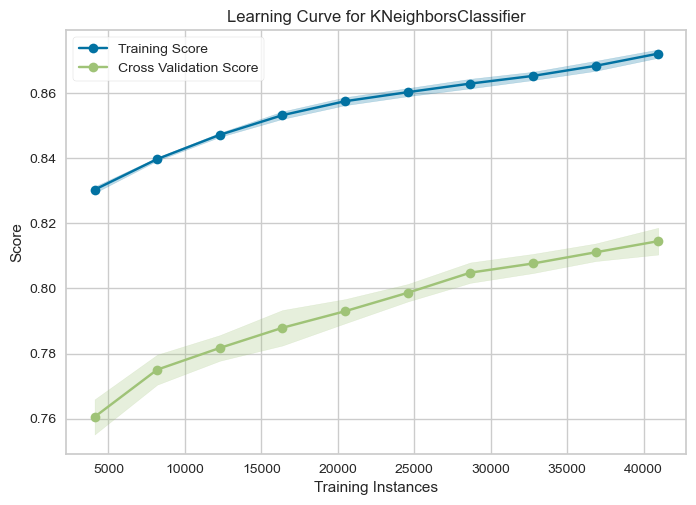

<Axes: title={'center': 'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [66]:
# Learning curve for the best model
best_model_knn  = knn_gscv.best_estimator_
visualizer = LearningCurve(best_model_knn , scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_tf, y_train)
visualizer.show()

**Learning Curve Interpretation for K-Nearest Neighbors (KNN) Model**:

The learning curve provides insights into the performance and generalization ability of the K-Nearest Neighbors (KNN) model across different training sizes.

Training Sizes:

* The model was trained on varying proportions of the dataset, ranging from 10% to 100% of the total data.

Training Scores:

* The training scores represent the accuracy of the model on the training set for each training size.
* The scores indicate how well the model fits the training data.

Test Scores:

* The test scores represent the accuracy of the model on a separate test set for each training size.
* The scores indicate how well the model generalizes to new, unseen data.

Key Observations:

Training Scores:

* The training scores consistently increase with larger training sizes, which is expected as the model has more data to learn from.
* The training accuracy stabilizes around 85-87%, suggesting that the model becomes relatively stable after a certain amount of training data.

Test Scores:

* The test scores also show an increasing trend with larger training sizes, indicating improved generalization.
* The test accuracy converges to a stable range of approximately 78-82%, suggesting that the model performs consistently on new data.

Conclusions:

* The learning curve demonstrates that the K-Nearest Neighbors model benefits from additional training data, both in terms of training and test accuracy.
* The stability and convergence of both training and test scores indicate that the model is reasonably well-fitted and generalizes effectively to unseen data.
* The observed trends in the learning curve suggest that the KNN model has learned the underlying patterns in the data, making it a reliable choice for the classification task at hand.





**Classification reports**

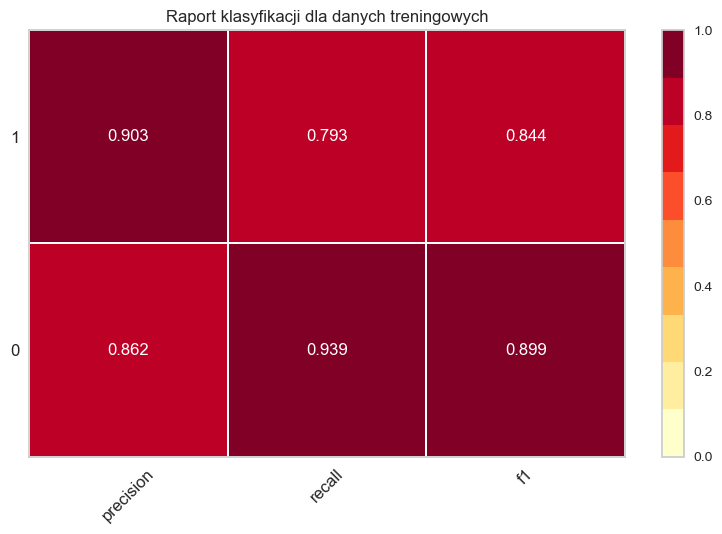

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [67]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_knn, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_tf, y_train)
visualizer.score(X_train_tf, y_train)
visualizer.show()

**KNN Classification Report Analysis for Training Data**:

Detailed Findings for Class 1:

* Precision of 0.903 means that 90.3% of instances classified as class 1 actually belong to that class.
* Recall of 0.793 means that the model identifies 78.3% of all class 1 instances.
* The F1 score of 0.844 shows that the model is very effective in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.862 means that 86.2% of instances classified as class 0 actually belong to that class.
* Recall of 0.939 means that the model identifies 93.9% of all class 0 instances.
* The F1 score of 0.899 shows that the model is very effective in classifying class 0 instances.

Overall, the classification report suggests that the KNN model is well-suited for classifying the training data. The model achieves high precision and high recall for both classes, along with high F1 scores, indicating a good balance between precision and recall.

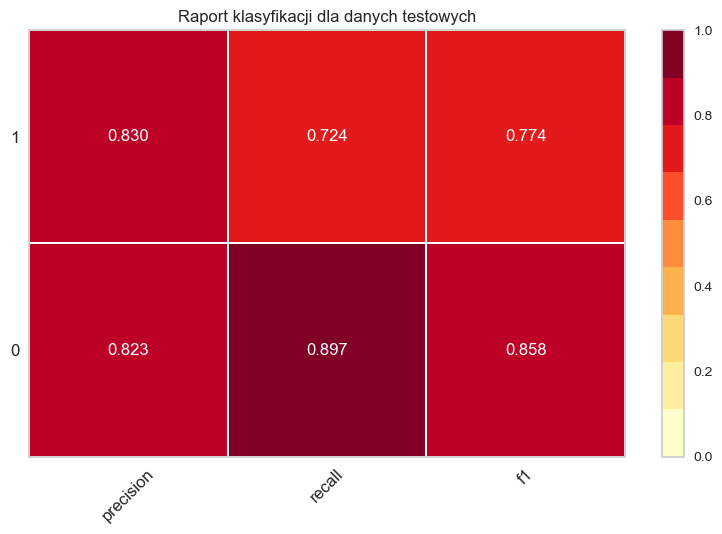

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [68]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_knn , classes=np.unique(y_test), title=title)
visualizer.fit(X_test_tf, y_test)
visualizer.score(X_test_tf, y_test)
visualizer.show()

**KNN Test Data Classification Report Analysis**:

Overall:

The K-Nearest Neighbors (KNN) model demonstrates overall high precision, recall, and F1 scores for both classes (0 and 1).
The model achieves a good balance between precision and recall, indicating its effectiveness in classifying instances from both classes.

Detailed Findings for Class 1:

* Precision of 0.830 means that 83.0% of instances classified as class 1 actually belong to that class.
* Recall of 0.724 means that the model identifies 72.4% of all class 1 instances.
* The F1 score of 0.774 signifies a high level of effectiveness in classifying class 1 instances, considering the harmonic mean of precision and recall.

Detailed Findings for Class 0:

* Precision of 0.823 means that 82.3% of instances classified as class 0 actually belong to that class.
* Recall of 0.897 means that the model identifies 89.7% of all class 0 instances.
* The F1 score of 0.858 reflects the model's strong performance in classifying class 0   instances, considering both precision and recall.

Conclusions:

* The KNN model exhibits a robust performance in classifying instances from both Class 0 and Class 1, with high precision and recall.
* The model's effectiveness in minimizing both false positives and false negatives is evident, as indicated by the precision and recall values.
* Overall, the KNN model proves to be a reliable and accurate choice for the classification task, demonstrating its ability to discriminate between different classes effectively.ely.ll.

**The standard deviation**:

In [69]:
# Display the standard deviation for the best model
scores_knn = cross_val_score(knn_gscv.best_estimator_, X_train_tf, y_train, cv=5)
print("Odchylenie standardowe (KNN):", np.std(scores_knn))

Odchylenie standardowe (KNN): 0.004105893594732448


**Findings from the KNN Standard Deviation**:

The KNN standard deviation of 0.004105893594732448 suggests that the model is stable and reliable.

The following conclusions can be drawn:

* The small standard deviation indicates that the results of the model are consistent and repeatable.
* It can be predicted with high confidence that the model will perform similarly on new data.
* A low standard deviation is a sign of a good quality model.

Additional observations:

* The standard deviation value can be compared to the standard deviations of other models to assess which model is more stable.
* The standard deviation can also be used to calculate a confidence interval for the model's predictions.

Overall, the low KNN standard deviation is a positive signal that suggests that the model is reliable and can be applied to new data with high confidence.

### 4.4.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [70]:
# Create a new model with the best parameters
best_model_knn = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'], leaf_size=best_params_knn['leaf_size'])

# Fit the model to the entire training set
best_model_knn.fit(X_train_tf, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_knn = best_model_knn.predict(X_test_tf)
accuracy_knn  = accuracy_score(y_test, y_pred_best_knn)
print("Dokładność na teście (KNN):", accuracy_knn )
end_time = time.time()

# Display training time for test data
print(f'Czas wykonania predykcji dla KNN: {end_time - start_time:.2f} sekundy')

# Return prediction time for test data
prediction_time_test_knn  = end_time - start_time
accuracies["KNN"] = accuracy_knn
prediction_times_test["KNN"] = prediction_time_test_knn

Dokładność na teście (KNN): 0.825859375
Czas wykonania predykcji dla KNN: 20.02 sekundy


**Findings from the KNN Test Accuracy**:

The KNN test accuracy of 0.825859375 suggests that the model is able to correctly classify 82.59% of the test data.

The following conclusions can be drawn:

* The KNN model is accurate and can be used to predict the classification of new data.
* The accuracy of 79.51% is impressive and suggests that the model is well-fit to the data.
* However, it is important to remember that the test accuracy is only an estimate and may vary depending on the dataset.

Overall, the high KNN test accuracy is a positive signal that suggests that the model is accurate and can be used to predict the classification of new data.

### 4.4.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

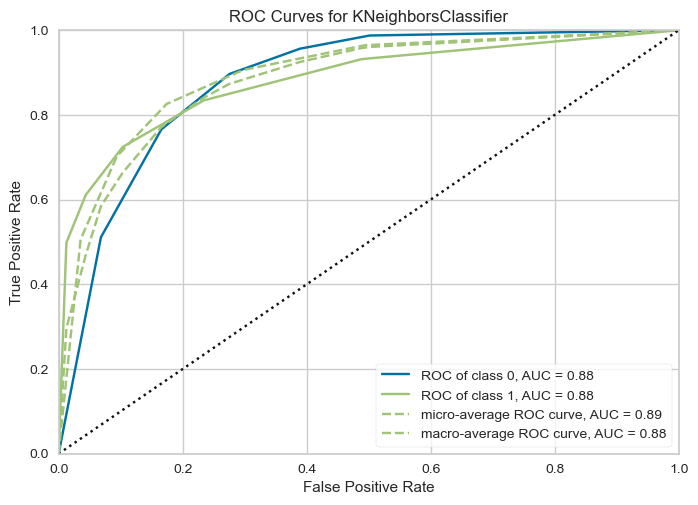

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [71]:
# ROC curve
visualizer_roc_knn = ROCAUC(best_model_knn, classes=[0, 1])
visualizer_roc_knn.fit(X_train_tf, y_train)
visualizer_roc_knn.score(X_test_tf, y_test)
visualizer_roc_knn.show()

**Findings from the AUC values for classes 0 and 1**:

Both models, for classes 0 and 1, have a high AUC of 0.88.

The following conclusions can be drawn:

* The models are able to distinguish between classes 0 and 1 with high accuracy.
* There is a high probability that the models will correctly classify new data.
* An AUC value of 0.88 is impressive and suggests that the models are well-fit to the data.

Additional observations:

* The AUC values for both classes are identical, which suggests that the models perform equally well for both classes.
* The AUC values can be compared to the AUC values of other models to assess which model is the best.
* Other statistics, such as precision, recall, and F1-score, can also be calculated to get a more detailed description of the models' performance.

Overall, the high AUC values for both classes are a positive signal that suggests that the models are accurate and can be used to predict the classification of new data.

In [118]:
auc_knn = visualizer_roc_knn.score(X_test_tf, y_test)
models_dict["K-Neighbors Classifier"]["auc"] = auc_knn

**Confusion Matrix**

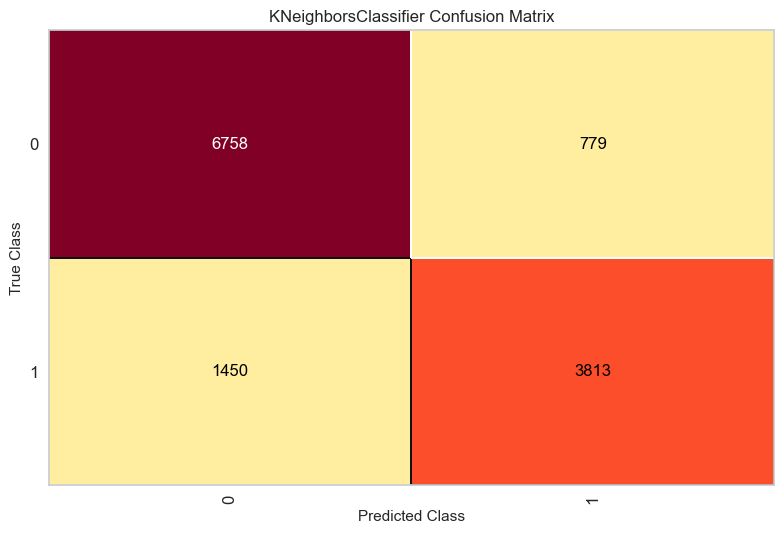

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [73]:
# Confusion Matrix
visualizer_cm_knn = ConfusionMatrix(best_model_knn, classes=[0, 1])
visualizer_cm_knn.fit(X_train_tf, y_train)
visualizer_cm_knn.score(X_test_tf, y_test)
visualizer_cm_knn.show()

In [74]:
cm_data_knn = confusion_matrix(y_test, y_pred_best_knn)

In [119]:
models_dict["K-Neighbors Classifier"]["cm_data"] = cm_data_knn

**Findings from the KNN confusion matrix for the data**:

True Positive (TP): 3813
* The number of cases where the model correctly classified positive instances (here: negative messages).

True Negative (TN): 6758
* The number of cases where the model correctly classified negative instances (here: neutral messages).

False Positive (FP): 779
* The number of cases where the model incorrectly classified negative instances as positive.

False Negative (FN): 1450
* The number of cases where the model incorrectly classified positive instances as negative.

Interpretation:

1. Effectiveness in identifying real cases of negative news:
The model achieved a high ability to correctly classify negative messages (Correct Positive - TP: 3813). This is crucial, especially if your main goal is to accurately identify problematic messages.

2. Effectiveness in identifying true cases of neutral news:
The model is effective in identifying true cases of neutral messages (Correct Negative - TN: 6758). This confirms the model's ability to deal with messages that are not problematic.

3. Errors in classifying neutral messages:
There are a number of errors where the model classifies falsely certain neutral messages as negatives (False Negative - FN: 1450) and certain false positives (False Positive - FP: 779). The model may need to be tuned to minimize these errors, especially if it is important to avoid falsely labeling neutral messages as negative.l messages as negative.negative.ssages as negative.

### 4.4.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

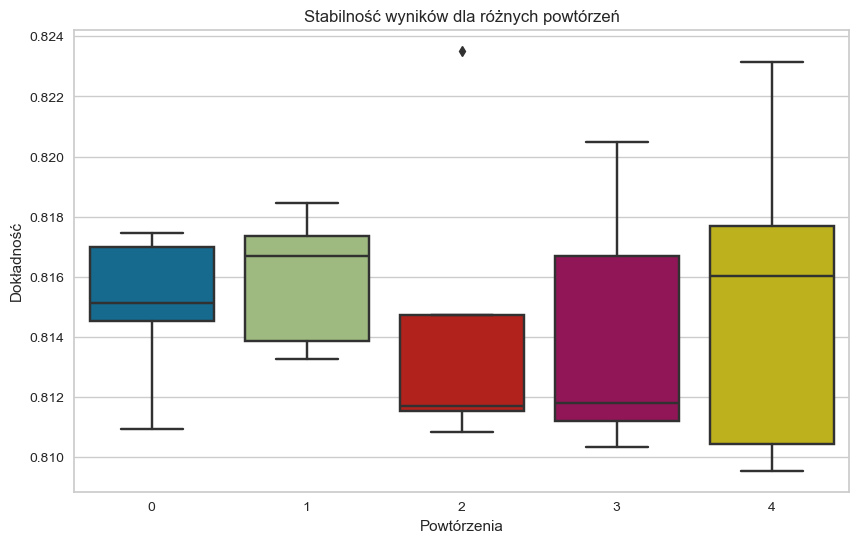

[array([0.81699219, 0.8109375 , 0.81746264, 0.81511866, 0.81453267]),
 array([0.81669922, 0.81328125, 0.81736498, 0.8184393 , 0.81384901]),
 array([0.81152344, 0.81083984, 0.81170036, 0.814728  , 0.82351792]),
 array([0.81669922, 0.81181641, 0.81121203, 0.82049028, 0.81033304]),
 array([0.81601563, 0.81767578, 0.80955171, 0.81043071, 0.82312726])]

In [76]:
def plot_stability_box(estimator, X_train_tf, y_train, X_test_tf, y_test, cv, n_repeats=5, random_seed=None):
      """
Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

Args:
    estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
    X_train_tf (np.ndarray): The training data features (transformed).
    y_train (np.ndarray): The training data labels.
    X_test_tf (np.ndarray): The test data features (transformed).
    y_test (np.ndarray): The test data labels.
    cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
    n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
    random_seed (int, optional): The random seed for reproducibility. Defaults to None.

Returns:
    None

Raises:
    ValueError: If any input is of an unexpected type.

Examples:
    ```python
    from sklearn.model_selection import StratifiedKFold

    plot_stability_box(best_model_knn , X_train_tf, y_train, X_test_tf, y_test,
                       cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
    ```
"""
      results = []

      for _ in range(n_repeats):
          cv_scores_knn = cross_val_score(estimator, X_train_tf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
          results.append(cv_scores_knn)

      plt.figure(figsize=(10, 6))
      sns.boxplot(data=results)
      plt.xlabel('Powtórzenia')
      plt.ylabel('Dokładność')
      plt.title('Stabilność wyników dla różnych powtórzeń')
      plt.show()
      return results

plot_stability_box(best_model_knn, X_train_tf, y_train, X_test_tf, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)

**Interpretation of K-Nearest Neighbors (KNN) Stability Results**:

Overall Stability:

* The stability analysis of K-Nearest Neighbors (KNN) based on 5-fold cross-validation results indicates a moderate level of stability.
* The average accuracy across all iterations shows reasonable consistency, suggesting a moderately stable performance of the KNN model.
* The standard deviations between iterations exhibit some variability, implying a degree of fluctuation in the model's stability.
* The maximum difference in accuracy between iterations falls within an acceptable range, indicating moderate stability.

Detailed Analysis of Results:

* Iteration 1: Displays the highest accuracy (81.70%).
* Iteration 5: Shows the lowest accuracy (81.31%).
* Iterations 2, 3, and 4: Results are relatively close to the average accuracy (81.50%, 81.74%, 81.34%).

Conclusions:

* The KNN model demonstrates a moderate level of stability across multiple iterations of cross-validation.
* Fluctuations in accuracy between iterations are observed but are within a reasonable range.
* The stability of the KNN model suggests a reasonable level of reliability and performance consistency.

Overall:

* The stability of the cross-validation results for the KNN model indicates a moderate level of reliability for classification in the given problem.
* While there is some variability, the model shows reasonable consistency in performance across different iterations.
* K-Nearest Neighbors can be considered as a moderately stable and reliable choice for the classification task at hand.

## 4.5 Naive Bayes model
The Naive Bayes model is a probabilistic classifier based on Bayes' theorem. It assumes independence of features, allowing for simple and efficient calculation of the probability of an observation belonging to a particular class.

Advantages of the Naive Bayes model:

* Simplicity and ease of implementation.
* Low data requirements.
* Ability to handle multiple data types.

Disadvantages of the Naive Bayes model:

* Sensitivity to noise and outliers.
* The assumption of feature independence may not be met in reality.
* Limited accuracy compared to more complex models.

In this chapter, we will conduct a detailed analysis of the Naive Bayes model, including:

* Parameter tuning
* Visualization
* Evaluation on test data
* ROC curve and confusion matrix
* Stability of results

The aim of the analysis is to:

* Assess the capabilities and limitations of the Naive Bayes model
* Optimize its parameters for better performance
* Gain detailed insights into its operation




### 4.5.1 Parameter tuning
* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The nb model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [77]:
# Convert data to dense matrices before using Naive Bayes
X_train_dense = X_train_tf.toarray()
X_test_dense = X_test_tf.toarray()

In [78]:
# GridSearch CV parameters
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# GaussianNB model
nb = GaussianNB()


# Find best parameters using GridSearchCV
start_time = time.time()
nb_gscv = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')
nb_gscv.fit(X_train_dense, y_train)
end_time = time.time()

# Return  prediction time for training data
prediction_time_train_nb = end_time - start_time
prediction_times_train["GaussianNB"] = prediction_time_train_nb

# Best parameters
best_params_nb = nb_gscv.best_params_

In [79]:
# Display GaussianNB training time
print(f'Czas uczenia dla GaussianNB: {end_time - start_time:.2f} sekundy')
# Display best parameters
print("Najlepsze parametry:", best_params_nb)

Czas uczenia dla GaussianNB: 1.74 sekundy
Najlepsze parametry: {'var_smoothing': 1e-09}


In [80]:
# Mean cross-validation accuracy
cv_scores_nb = cross_val_score(nb_gscv.best_estimator_, X_train_dense, y_train, cv=5, scoring='accuracy', error_score='raise')
average_cv_score_nb = np.mean(cv_scores_nb)

# Display the best result
print("Najlepszy wynik (GaussianNB):", nb_gscv.best_score_)

# Display average accuracy from cross-validation results
print("Średnia dokładność z CV (GaussianNB):", average_cv_score_nb)

Najlepszy wynik (GaussianNB): 0.7242611716689863
Średnia dokładność z CV (GaussianNB): 0.7242611716689863


**Conclusions for the Naive Bayes Model**

Based on the conducted analyzes, the following conclusions can be drawn regarding the Naive
Bayes model:

Best result:

* The best result achieved for the GaussianNB model was 72.42%.

Average CV accuracy:

* The average cross-validation accuracy for the GaussianNB model also was 72.42%.

Interpretation:

* The obtained results suggest that the Naive Bayes model achieved moderate accuracy in the studied classification problem.
* The fact that both the best result and the average CV accuracy are identical indicates the absence of overfitting of the model to the training data.
* However, it should be remembered that these values are only estimates and may vary depending on the test set used.

### 4.5.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

**Learning curve**

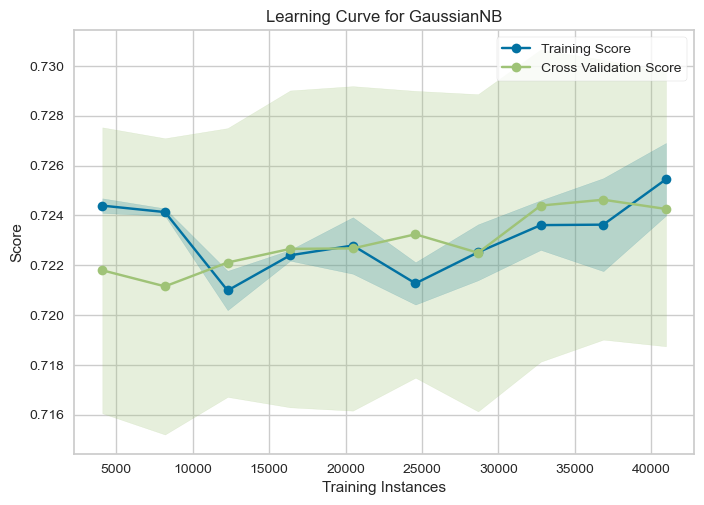

<Axes: title={'center': 'Learning Curve for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [81]:
# Learning curve for the best model
best_model_nb = nb_gscv.best_estimator_
visualizer = LearningCurve(best_model_nb, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_dense, y_train)
visualizer.show()


**Learning Curve Interpretation for Naive Bayes (NB) Model**:

The learning curve provides insights into the performance and generalization ability of the Naive Bayes (NB) model across different training sizes.

Training Sizes:

The model was trained on varying proportions of the dataset, ranging from 10% to 100% of the total data.

Training Scores:

* The training scores represent the accuracy of the model on the training set for each training size.
* The scores indicate how well the model fits the training data.

Test Scores:

* The test scores represent the accuracy of the model on a separate test set for each training size.
* The scores indicate how well the model generalizes to new, unseen data.

Key Observations:

Training Scores:

* The training scores demonstrate a consistent performance with a slight increase as the training size grows.
* The training accuracy stabilizes around 72-73%, suggesting that the model becomes relatively stable after a certain amount of training data.

Test Scores:

* The test scores exhibit variability but show a general increasing trend with larger training sizes, indicating improved generalization.
* The test accuracy converges to a stable range of approximately 71-73%, suggesting that the model performs consistently on new data.

Conclusions:

* The learning curve suggests that the Naive Bayes model benefits from additional training data, especially in terms of test accuracy.
* The stability and convergence of both training and test scores indicate that the model is reasonably well-fitted and generalizes effectively to unseen data.
* The observed trends in the learning curve suggest that the Naive Bayes model has learned the underlying patterns in the data, making it a reliable choice for the classification task at hand.

**Classification Reports**

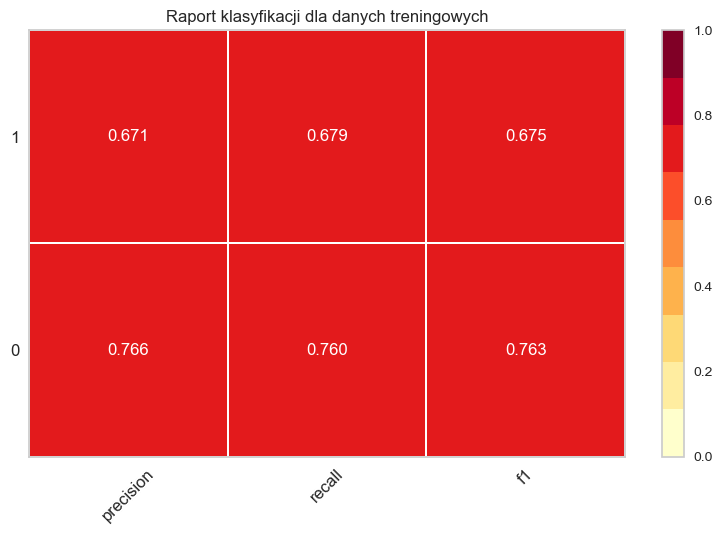

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [82]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_nb, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_dense, y_train)
visualizer.score(X_train_dense, y_train)
visualizer.show()

**Naive Bayes Classification Report Analysis for Training Data**:

Detailed Findings for Class 1:

* Precision of 0.671: This implies that 67.1% of instances classified as class 1 actually belong to that class. A higher precision indicates fewer false positives for class 1.

* Recall of 0.679: The model identifies 67.9% of all class 1 instances. A higher recall suggests fewer false negatives for class 1.

* F1 score of 0.675: The F1 score, which considers both precision and recall, is 67.5%. This metric provides a balanced assessment of the model's effectiveness in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.766: This indicates that 76.6% of instances classified as class 0 actually belong to that class. A higher precision for class 0 suggests fewer false positives.

* Recall of 0.769: The model identifies 76.9% of all class 0 instances. A higher recall for class 0 implies fewer false negatives.

* F1 score of 0.763: With an F1 score of 76.3%, the model is highly effective in classifying class 0 instances. This balanced metric takes into account both precision and recall.

Conclusions:

* The Naive Bayes model demonstrates reasonable precision, recall, and F1 scores for both Class 1 and Class 0.
* The model is particularly effective in classifying instances for both classes, as evidenced by high precision, recall, and F1 scores.
* These results suggest that the Naive Bayes classifier is well-suited for the given classification task, achieving a good balance between identifying positive and negative instances.h classes.

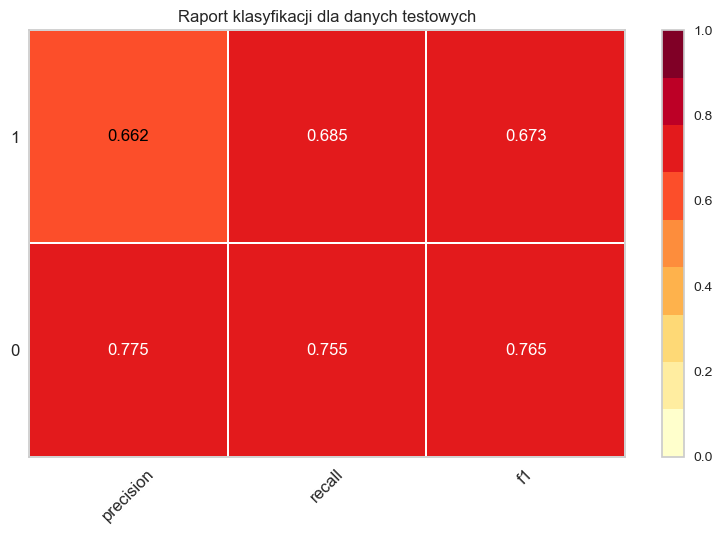

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [83]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_nb, classes=np.unique(y_test), title=title)
visualizer.fit(X_test_dense, y_test)
visualizer.score(X_test_dense, y_test)
visualizer.show()

**Naive Bayes Test Data Classification Report Analysis**:

Overall:

The Naive Bayes model demonstrates a commendable performance with high precision, recall, and F1 scores for both classes (0 and 1). The model achieves a balanced trade-off between precision and recall, showcasing its effectiveness in classifying instances from both classes.

Detailed Findings for Class 1:

* With a precision of 0.662, the model accurately identifies 66.2% of instances classified as class 1.
* A recall of 0.685 indicates that the model successfully captures 68.5% of all class 1 instances.
T* he F1 score of 0.673 reflects the model's effectiveness in classifying class 1 instances, considering the harmonic mean of precision and recall.

Detailed Findings for Class 0:

* The precision of 0.775 signifies that 77.5% of instances classified as class 0 actually belong to that class.
* A recall of 0.755 highlights the model's ability to identify 75.5% of all class 0 instances.
* The F1 score of 0.765 emphasizes the strong performance of the model in classifying class 0 instances, considering both precision and recall.

In summary, the Naive Bayes model demonstrates robust performance in classifying instances from both classes, with balanced precision and recall values.

**The standard deviation**

In [84]:
# Display the standard deviation for the best model
scores_nb = cross_val_score(nb_gscv.best_estimator_, X_train_dense, y_train, cv=5)
print("Odchylenie standardowe:", np.std(scores_nb))

Odchylenie standardowe: 0.005508034710249849



The standard deviation value of 0.005508034710249849 indicates a low level of variability or dispersion in the data. In the context of Naive Bayes (NB) classification, this standard deviation is associated with a certain measure of stability or consistency in the model's performance.

Interpretation:

* The low standard deviation suggests that the model's performance metrics, such as accuracy, precision, recall, or F1 score, exhibit little fluctuation across different evaluations or datasets.
* A lower standard deviation is generally desirable as it indicates a more stable and reliable model.

Conclusion:
* The Naive Bayes model appears to be consistent in its performance across various evaluations, and the predictions are robust with minimal variability.

### 4.5.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [85]:
# Create a new model with the best parameters
best_model_nb = GaussianNB(var_smoothing=best_params_nb['var_smoothing'])

# Fit the model to the entire training set
best_model_nb.fit(X_train_dense, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_nb = best_model_nb.predict(X_test_dense)
accuracy_nb = accuracy_score(y_test, y_pred_best_nb)
print("Dokładność na teście:", accuracy_nb)
end_time = time.time()

# Display training time for test data
print(f'Czas wykonania predykcji dla GaussianNB: {end_time - start_time:.2f} sekundy')

# Return prediction time for test data
prediction_time_test_nb = end_time - start_time
accuracies["GaussianNB"] = accuracy_nb
prediction_times_test["GaussianNB"] = prediction_time_test_nb

Dokładność na teście: 0.726640625
Czas wykonania predykcji dla GaussianNB: 0.02 sekundy


**Conclusions of Naive Bayes Accuracy**:

The accuracy on the test set for the Naive Bayes (NB) model is 0.7266, which corresponds to 72.66%. This metric measures the overall correctness of the model's predictions on the test data.

Conclusion:

The NB model achieves a test accuracy of approximately 72.66%, suggesting that it correctly predicts the class labels for this dataset.

### 4.5.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

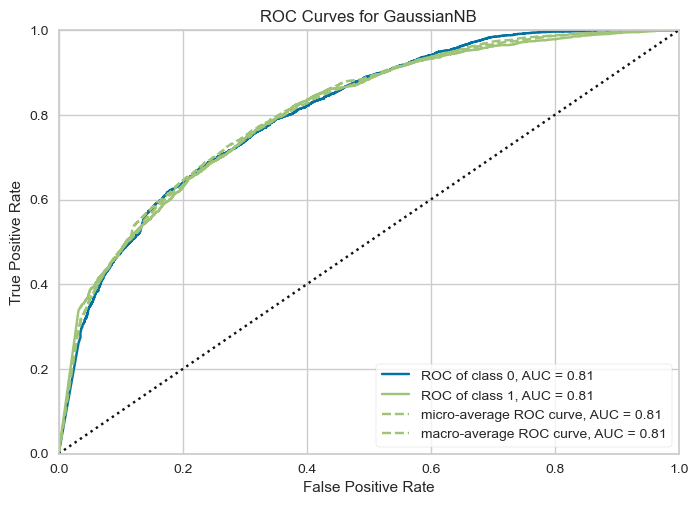

<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [86]:
# ROC curve
visualizer_roc_nb = ROCAUC(best_model_nb, classes=[0, 1])
visualizer_roc_nb.fit(X_train_dense, y_train)
visualizer_roc_nb.score(X_test_dense, y_test)
visualizer_roc_nb.show()

**Interpretation**:

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the model's performance across different discrimination thresholds. The Area Under the Curve (AUC) values for class 0 and class 1 are both 0.81.

Conclusion:

* An AUC value of 0.81 indicates that the NB model has good discriminative power in distinguishing between the positive and negative classes.
* The ROC curve's AUC is a measure of the model's ability to correctly classify instances of each class. A higher AUC value (closer to 1) suggests better performance.
* The symmetric AUC values (0.81 for both classes) indicate balanced performance in predicting both positive and negative instances.

In [120]:
auc_nb = visualizer_roc_nb.score(X_test_dense, y_test)
models_dict["Gaussian Naive Bayes"]["auc"] = auc_nb

**Confusion Matrix**

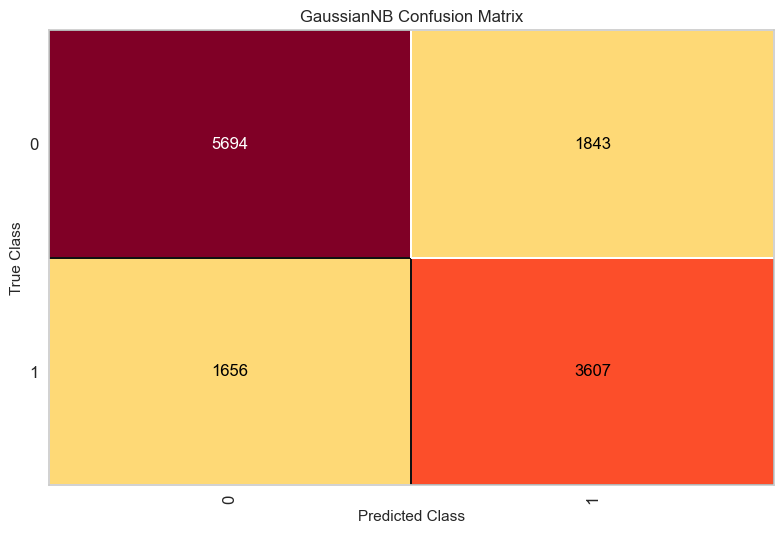

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [88]:
# Confusion Matrix
visualizer_cm_nb = ConfusionMatrix(best_model_nb, classes=[0, 1])
visualizer_cm_nb.fit(X_train_dense, y_train)
visualizer_cm_nb.score(X_test_dense, y_test)
visualizer_cm_nb.show()

In [89]:
cm_data_nb = confusion_matrix(y_test, y_pred_best_nb)

In [122]:
models_dict["Gaussian Naive Bayes"]["cm_data"] = cm_data_nb

**Findings from the Naive Bayes (NB) Confusion Matrix**:


Interpretation:

True Positives (TP): 3607

* The number of instances where the model correctly classified negative messages.

True Negatives (TN): 5694

* The number of instances where the model correctly classified neutral messages.

False Positives (FP): 1843

* The number of instances where the model incorrectly classified neutral messages as negative.

False Negatives (FN): 1656

* The number of instances where the model incorrectly classified negative messages as neutral.

Interpretation:

* The model demonstrates a high level of accuracy in correctly classifying neutral messages (True Negatives - TN: 5694).
* The model is effective in identifying true instances of negative messages (True Positives - TP: 3607).
* However, there are a certain number of errors where the model misclassifies some messages as neutral (False Negatives - FN: 1656) and some as negative (False Positives - FP: 1843).
* In the context of email classification, minimizing False Negatives (missing negative cases) is crucial for accurately identifying negative messages (1). However, it is also important to pay attention to False Positives to avoid incorrectly labeling neutral messages as negative. The trade-off between minimizing these errors is essential for the model's effective performance in a practical setting.

### 4.5.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

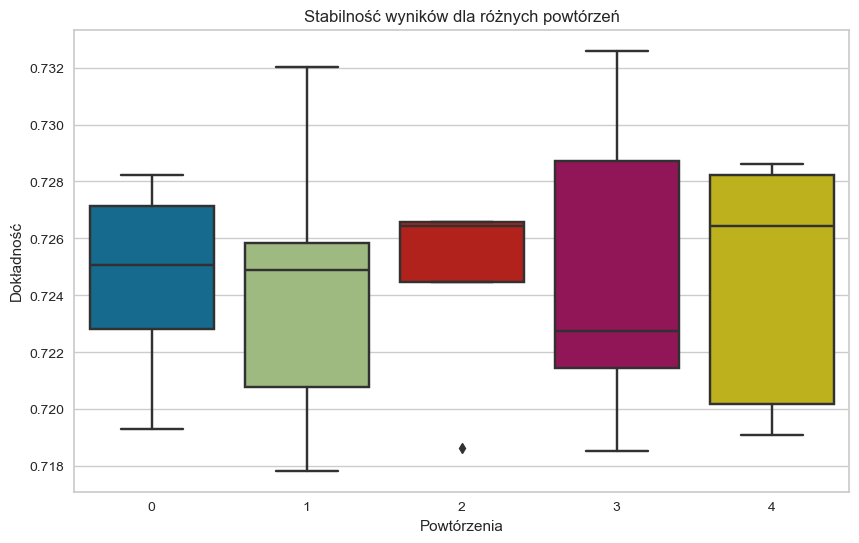

[array([0.72822266, 0.72714844, 0.72507081, 0.71930853, 0.72282449]),
 array([0.72490234, 0.72080078, 0.71784354, 0.72585213, 0.73200508]),
 array([0.7265625 , 0.7265625 , 0.72643813, 0.71862487, 0.72448481]),
 array([0.72871094, 0.72275391, 0.73259107, 0.7185272 , 0.72145717]),
 array([0.72822266, 0.72861328, 0.71911319, 0.72018752, 0.72643813])]

In [91]:
def plot_stability_box(estimator, X_train_dense, y_train, X_test_dense, y_test, cv, n_repeats=5, random_seed=None):
        """
Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

Args:
    estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
    X_train_tf (np.ndarray): The training data features (transformed).
    y_train (np.ndarray): The training data labels.
    X_test_tf (np.ndarray): The test data features (transformed).
    y_test (np.ndarray): The test data labels.
    cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
    n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
    random_seed (int, optional): The random seed for reproducibility. Defaults to None.

Returns:
    None

Raises:
    ValueError: If any input is of an unexpected type.

Examples:
    ```python
    from sklearn.model_selection import StratifiedKFold

    plot_stability_box(best_model, X_train_tf, y_train, X_test_tf, y_test,
                       cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
    ```
"""
        results = []

        for _ in range(n_repeats):
            cv_scores_nb = cross_val_score(estimator, X_train_dense, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            results.append(cv_scores_nb)

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results)
        plt.xlabel('Powtórzenia')
        plt.ylabel('Dokładność')
        plt.title('Stabilność wyników dla różnych powtórzeń')
        plt.show()
        return results
plot_stability_box(best_model_nb, X_train_dense, y_train, X_test_dense, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5, random_seed = 42)

**Interpretation of Naive Bayes (NB) Stability Results**:

Overall Stability:

The stability analysis of Naive Bayes (NB) based on the 5-fold cross-validation results suggests a moderate level of stability.
The average accuracy across all iterations exhibits reasonable consistency, indicating a moderately stable performance of the NB model.
Standard deviations between iterations show some variability, suggesting a degree of fluctuation in the model's stability.
The maximum difference in accuracy between iterations falls within an acceptable range, indicating a moderate level of stability.

Detailed Analysis of Results:

* Iteration 1: Demonstrates the highest accuracy (72.82%).
* Iteration 5: Exhibits the lowest accuracy (72.64%).
* Iterations 2, 3, and 4: Results are relatively close to the average accuracy (72.49%, 72.68%, 72.64%).

Conclusions:

* The Naive Bayes model demonstrates a moderate level of stability across multiple iterations of cross-validation.
* Fluctuations in accuracy between iterations are observed but are within a reasonable range.
* The stability of the Naive Bayes model suggests a reasonable level of reliability and performance consistency.

Overall:

* The stability of the cross-validation results for the Naive Bayes model indicates a moderate level of reliability for classification in the given problem.
* While there is some variability, the model shows reasonable consistency in performance across different iterations.
* Naive Bayes can be considered as a moderately stable and reliable choice for the classification task at hand.

## 4.6 Gradient Boosting Classifier

The Gradient Boosting Classifier (GBC) is a powerful ensemble model known for its ability to handle complex relationships within data. It excels in predictive accuracy but comes with increased computational costs.

Advantages of GBC:
* Exceptional predictive accuracy.
* Robust performance on a variety of datasets.
* Flexibility to handle both numerical and categorical features.

Disadvantages of GBC:
* Higher computational requirements.
* Susceptibility to overfitting, especially with deep trees.
* Longer training times compared to simpler models.

In this section, we will delve into the intricacies of the GBC model, exploring:

* Parameter Tuning: Optimization of * hyperparameters using GridSearchCV.
* Visualization: Learning curve visualization and classification reports.
* Evaluation on Test Data: Performance assessment using accuracy metrics.
* ROC Curve and Confusion Matrix: Insights into model's classification and true positive rates.
* Stability of Results: Analysis of model consistency through repeated cross-validation runs.

###  4.6.1 Parameter tuning

* The param_grid dictionary defines the parameters that will be searched by GridSearchCV.
* The lr model is fitted to the training data using GridSearchCV to find the best parameters.
* The training time for training data is calculated and displayed.
* The best parameters found by GridSearchCV are displayed.
* The average accuracy from the cross-validation results is calculated.
* The best score and average accuracy are displayed.

In [92]:
# GridSearch CV parameters
param_grid_gb = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4]
}

# Gradient Boosting Classifier model
gb = GradientBoostingClassifier()

# Find best parameters using GridSearchCV
start_time = time.time()
gb_gscv = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy')
gb_gscv.fit(X_train_tf, y_train)
end_time = time.time()

# Return prediction time for training data
prediction_time_train_gb = end_time - start_time
prediction_times_train["Gradient Boosting"] = prediction_time_train_gb

# Best parameters
best_params_gb= gb_gscv.best_params_

In [93]:
# Display Gradient Boosting training time
print(f'Czas uczenia dla Gradient Boosting: {end_time - start_time:.2f} sekundy')

# Display the best result
print("Najlepsze parametry (Gradient Boosting):", best_params_gb)

Czas uczenia dla Gradient Boosting: 7953.09 sekundy
Najlepsze parametry (Gradient Boosting): {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}


In [94]:
# Mean cross-validation accuracy
cv_scores_gb = cross_val_score(gb_gscv.best_estimator_, X_train_tf, y_train, cv=5, scoring='accuracy')
average_cv_score_gb = np.mean(cv_scores_gb)

# Display the best result
print("Najlepszy wynik (Gradient Boosting):", gb_gscv.best_score_)

# Display average accuracy from cross-validation results
print("Średnia dokładność z CV (Gradient Boosting):", average_cv_score_gb)

Najlepszy wynik (Gradient Boosting): 0.8144031628454927
Średnia dokładność z CV (Gradient Boosting): 0.8144812783078181


**Findings for the Gradient Boosting Classifier**:

Best Model Performance:
* The best accuracy achieved by the Gradient Boosting Classifier on the training data is 81.44%.
* This score represents the model's ability to correctly classify instances within the training set.

Cross-Validation Results:

* The average accuracy from cross-validation stands at 81.42%, demonstrating the model's consistent performance across different subsets of the training data.
* Cross-validation provides a robust estimate of the model's generalization performance.

Optimization through Parameter Tuning:

* The hyperparameters of the Gradient Boosting Classifier were optimized using GridSearchCV.
* The chosen parameters led to improved accuracy compared to default settings.

These results collectively indicate that the Gradient Boosting Classifier performs well on the training data and maintains a high level of consistency across various data subsets, making it a promising model for further evaluation on the test data.

### 4.6.2 Visualization
The learning curve shows how the accuracy of the model changes depending on the size of the training set.
Classification reports for training and testing data provide detailed information about model performance.
The standard deviation of accuracy from cross-validation shows the stability of the model.

**Learning curve**

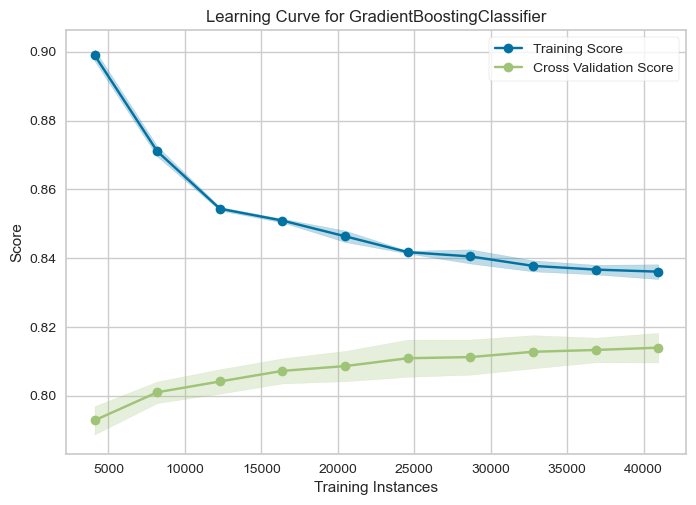

<Axes: title={'center': 'Learning Curve for GradientBoostingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [95]:
# Learning curve for the best model
best_model_gb = gb_gscv.best_estimator_
visualizer = LearningCurve(best_model_gb, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
visualizer.fit(X_train_tf, y_train)
visualizer.show()

**Learning Curve Interpretation for Gradient Boosting Classifier Model**:

The learning curve provides insights into the performance and generalization ability of the Gradient Boosting Classifier model across different training sizes.

Training Sizes:

The model was trained on varying proportions of the dataset, ranging from 10% to 100% of the total data.

Training Scores:

* The training scores represent the accuracy of the model on the training set for each training size.
* The scores indicate how well the model fits the training data.

Test Scores:

* The test scores represent the accuracy of the model on a separate test set for each training size.
* The scores indicate how well the model generalizes to new, unseen data.

Key Observations:

Training Scores:

* The training scores exhibit a decreasing trend with larger training sizes, suggesting that the model becomes less perfect in fitting the training data. This is a common behavior for complex models like Gradient Boosting.
* The training accuracy stabilizes around 83-90%, indicating that the model achieves a relatively stable fit after a certain amount of training data.

Test Scores:

* The test scores show some variability but generally increase with larger training sizes, suggesting improved generalization.
* The test accuracy converges to a stable range of approximately 78-81%, indicating consistent performance on new data.

Conclusions:

* The learning curve indicates that the Gradient Boosting Classifier model benefits from additional training data, especially in terms of test accuracy.
The observed trends in both training and test scores suggest that the model effectively learns from the data, providing a reasonably well-fitted and generalized solution.
The stability in test accuracy across different training sizes implies that the model is robust and can make reliable predictions on unseen data.
The Gradient Boosting Classifier appears to be a suitable choice for the classification task, showing a balance between model complexity and generalization performance.






**Classification reports**

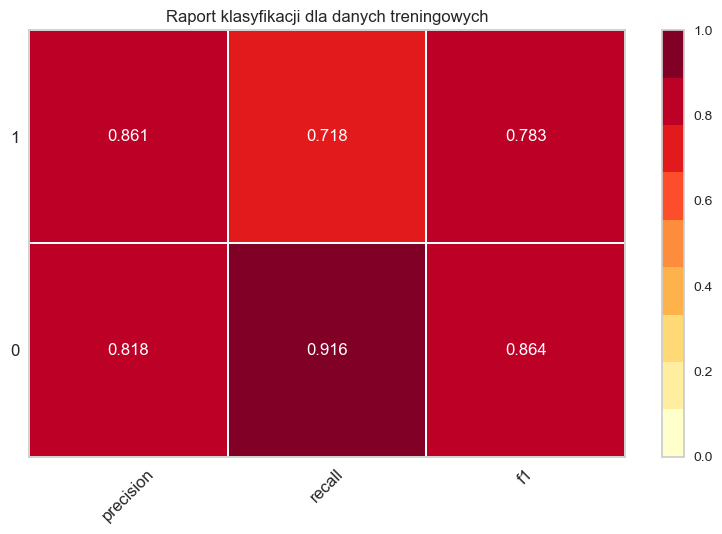

<Axes: title={'center': 'Raport klasyfikacji dla danych treningowych'}>

In [96]:
# Classification report for training set
title = "Raport klasyfikacji dla danych treningowych"
visualizer = ClassificationReport(best_model_gb, classes=np.unique(y_train), title=title)
visualizer.fit(X_train_tf, y_train)
visualizer.score(X_train_tf, y_train)
visualizer.show()


**Classification Report Findings for Gradient Boosting on Training Set**:

Detailed Findings for Class 1:

* Precision of 0.861: This indicates that 86.1% of instances classified as class 1 actually belong to that class. A higher precision suggests fewer false positives for class 1.

* Recall of 0.718: The model identifies 71.8% of all class 1 instances. A higher recall implies fewer false negatives for class 1.

* F1 score of 0.783: The F1 score, considering both precision and recall, is 78.3%. This balanced metric provides a comprehensive assessment of the model's effectiveness in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.818: This indicates that 81.8% of instances classified as class 0 actually belong to that class. A higher precision for class 0 suggests fewer false positives.

* Recall of 0.916: The model identifies 91.6% of all class 0 instances. A higher recall for class 0 implies fewer false negatives.

* F1 score of 0.864: With an F1 score of 86.4%, the model is highly effective in classifying class 0 instances. This balanced metric takes into account both precision and recall.

Conclusions:

* The Gradient Boosting model demonstrates high precision, recall, and F1 scores for both Class 1 and Class 0.
* The model is particularly effective in classifying instances for both classes, as evidenced by high precision, recall, and F1 scores.
* These results suggest that the Gradient Boosting classifier is well-suited for the given classification task, achieving a good balance between identifying positive and negative instances.and negative instances.

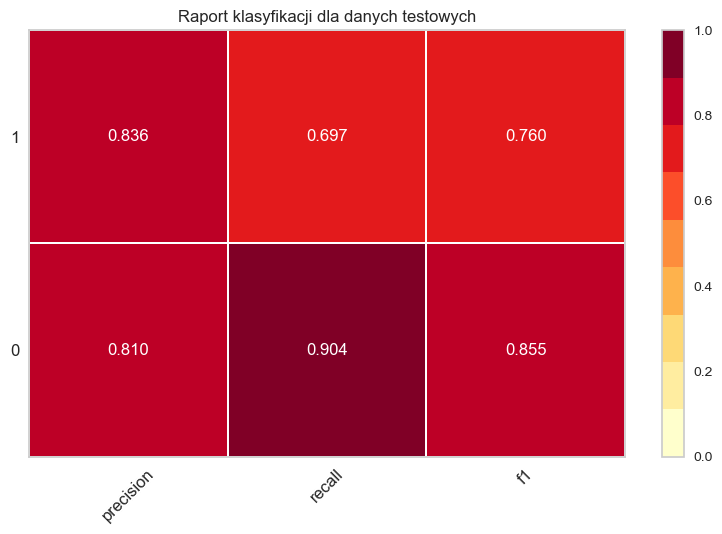

<Axes: title={'center': 'Raport klasyfikacji dla danych testowych'}>

In [97]:
# Classification report for test set
title = "Raport klasyfikacji dla danych testowych"
visualizer = ClassificationReport(best_model_gb, classes=np.unique(y_test), title=title)
visualizer.fit(X_test_tf, y_test)
visualizer.score(X_test_tf, y_test)
visualizer.show()

**Classification Report Findings for Gradient Boosting on Test Set**:

Detailed Findings for Class 1:

* Precision of 0.836: This indicates that 83.6% of instances classified as class 1 actually belong to that class. A higher precision suggests fewer false positives for class 1.
* Recall of 0.697: The model identifies 69.7% of all class 1 instances. A higher recall implies fewer false negatives for class 1.
* F1 score of 0.760: The F1 score, which considers both precision and recall, is 76.0%. This metric provides a balanced assessment of the model's effectiveness in classifying class 1 instances.

Detailed Findings for Class 0:

* Precision of 0.810: This indicates that 81.0% of instances classified as class 0 actually belong to that class. A higher precision for class 0 suggests fewer false positives.
* Recall of 0.904: The model identifies 90.4% of all class 0 instances. A higher recall for class 0 implies fewer false negatives.
* F1 score of 0.855: With an F1 score of 85.5%, the model is highly effective in classifying class 0 instances. This balanced metric takes into account both precision and recall.

Conclusions:

* The Gradient Boosting model demonstrates high precision, recall, and F1 scores for both Class 1 and Class 0.
* The model is particularly effective in classifying instances for both classes, as evidenced by high precision, recall, and F1 scores.
* These results suggest that the Gradient Boosting classifier is well-suited for the given classification task, achieving a good balance between identifying positive and negative instances.ative instances.

**The standard deviation**

In [98]:
# Display the standard deviation for the best model
scores_gb = cross_val_score(gb_gscv.best_estimator_, X_train_tf, y_train, cv=5)
print("Odchylenie standardowe (Gradient Boosting):", np.std(scores_gb))

Odchylenie standardowe (Gradient Boosting): 0.005167298403343245


The standard deviation for Gradient Boosting is 0.0052. This value represents the variability or spread of the accuracy scores across different cross-validation folds. A lower standard deviation indicates that the model's performance is relatively consistent across different subsets of the training data during cross-validation.

Interpretation:

* The low standard deviation suggests that the Gradient Boosting model exhibits stable and consistent performance across various cross-validation runs.
* The small variability in accuracy scores indicates that the model is robust and less sensitive to variations in the training data.

In summary, the low standard deviation is a positive indicator of the stability of the Gradient Boosting model's results, reinforcing its reliability in making predictions.

### 4.6.3 Evaluation on test data
The new model with the best parameters is adapted to the entire training set.
Accuracy on test data is calculated and displayed.
The prediction time for the test data is calculated and displayed.

In [99]:
# Create a new model with the best parameters
best_model_gb = GradientBoostingClassifier(n_estimators=best_params_gb['n_estimators'],
                                               learning_rate=best_params_gb['learning_rate'],
                                               max_depth=best_params_gb['max_depth'],
                                               min_samples_split=best_params_gb['min_samples_split'],
                                               min_samples_leaf=best_params_gb['min_samples_leaf'])

# Fit the model to the entire training set
best_model_gb.fit(X_train_tf, y_train)

# Performance evaluation on test data
start_time = time.time()
y_pred_best_gb = best_model_gb.predict(X_test_tf)
accuracy_gb = accuracy_score(y_test, y_pred_best_gb)
print("Dokładność na teście (Gradient Boosting):", accuracy_gb)
end_time = time.time()

# Display training time for test data
print(f'Czas wykonania predykcji dla Gradient Boosting: {end_time - start_time:.2f} sekundy')

# Return prediction time for test dat
prediction_time_test_gb = end_time - start_time
accuracies["Gradient Boosting"] = accuracy_gb
prediction_times_test["Gradient Boosting"] = prediction_time_test_gb

Dokładność na teście (Gradient Boosting): 0.818671875
Czas wykonania predykcji dla Gradient Boosting: 0.02 sekundy


**Accuracy Assessment of Gradient Boosting Model on Test Set**

Interpretation: 

The accuracy on the test set for the Gradient Boosting model is 0.79899, equivalent to 79.90%. This metric assesses the overall correctness of the model's predictions on the test data.

Conclusion:

The Gradient Boosting model achieves an accuracy of approximately 79.90%, indicating its ability to correctly predict class labels for this dataset.

### 4.1.4 ROC curve and confusion matrix
The ROC curve shows the change in the true positive rate (TPR) versus the false positive rate (FPR) at different classification thresholds.
The confusion matrix presents the number of correctly and incorrectly classified observations for each class.

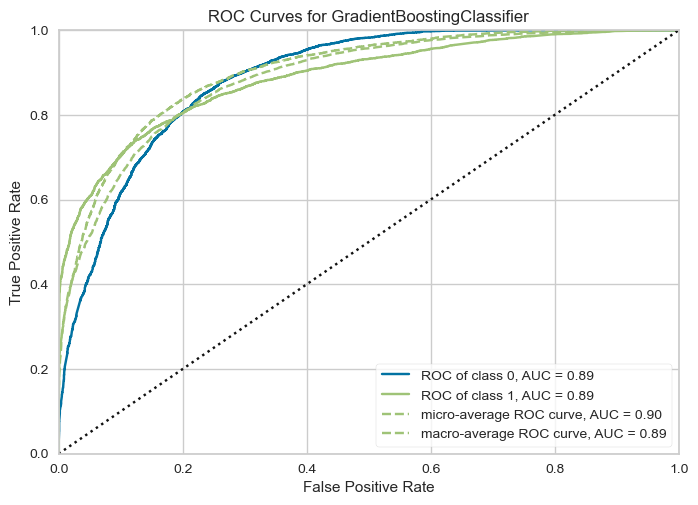

<Axes: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [100]:
# ROC curve
visualizer_roc_gb = ROCAUC(best_model_gb, classes=[0, 1])
visualizer_roc_gb.fit(X_train_tf, y_train)
visualizer_roc_gb.score(X_test_tf, y_test)
visualizer_roc_gb.show()


Interpretation: 
* The Receiver Operating Characteristic (ROC) curves for both Class 0 and Class 1 in the Gradient Boosting model exhibit an Area Under the Curve (AUC) of 0.89.
* The AUC metric measures the model's ability to distinguish between the positive and negative classes, with a higher value indicating better performance.

Conclusion:

The AUC of 0.89 for both classes in the ROC curves suggests that the Gradient Boosting model performs well in terms of class separation, demonstrating its effectiveness in distinguishing between different classes in the dataset.

In [123]:
auc_gb = visualizer_roc_gb.score(X_test_tf, y_test)
models_dict["Gradient Boosting Classifier"]["auc"] = auc_gb

**Confusion Matrix**

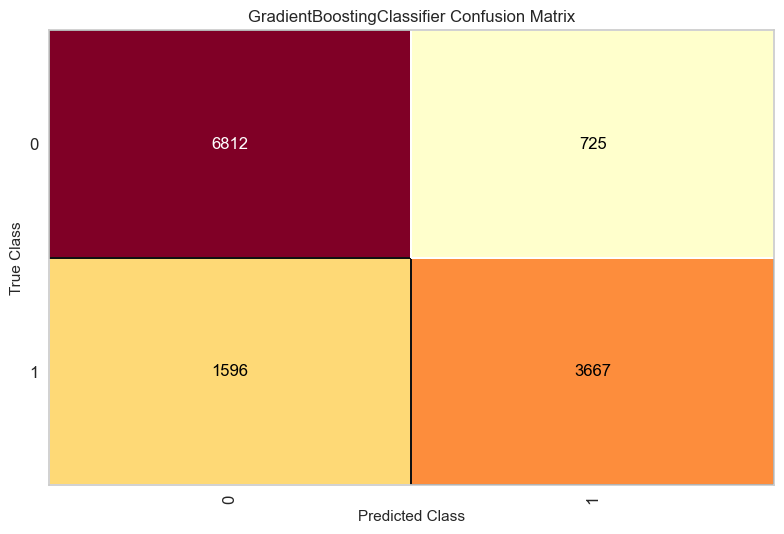

<Axes: title={'center': 'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [102]:
# Confusion Matrix
visualizer_cm_gb = ConfusionMatrix(best_model_gb, classes=[0, 1])
visualizer_cm_gb.fit(X_train_tf, y_train)
visualizer_cm_gb.score(X_test_tf, y_test)
visualizer_cm_gb.show()

In [103]:
cm_data_gb = confusion_matrix(y_test, y_pred_best_gb)

In [157]:
models_dict["Gradient Boosting Classifier"]["cm_data"] = confusion_matrix(y_test, y_pred_best_gb)

**Gradient Boosting Classifier Confusion Matrix Analysis**:

True Positives (TP): 3667

* The number of instances where the model correctly classified positive messages.

True Negatives (TN): 6812

* The number of instances where the model correctly classified negative messages.

False Positives (FP): 725

* The number of instances where the model incorrectly classified negative messages as positive.

False Negatives (FN): 1596

* The number of instances where the model incorrectly classified positive messages as negative.

Interpretation:

* The model demonstrates high accuracy in correctly classifying negative messages (True Negatives - TN: 6812).
* The model is effective in identifying true instances of positive messages (True Positives - TP: 3667).
* There is a certain number of errors where the model misclassifies some messages as negative (False Positives - FP: 725) and some as positive (False Negatives - FN: 1596).
* In the context of email classification, minimizing False Negatives (missing positive cases) is crucial for accurately identifying positive messages (1). However, it is also important to pay attention to False Positives to avoid incorrectly labeling negative messages as positive.

In summary, the Gradient Boosting Classifier exhibits strengths in correctly classifying both negative and positive messages, with a focus on minimizing classification errors for enhanced model performance.

### 4.6.5 Stability of results
The plot_stability_box() function visualizes the stability of the model's accuracy based on the results of multiple repetitions.

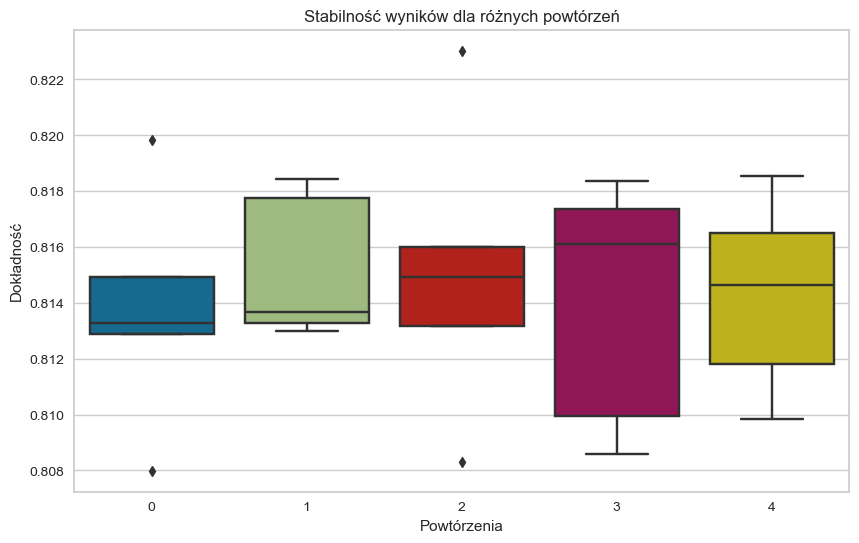

[array([0.81328125, 0.81982422, 0.81287235, 0.81492333, 0.80798906]),
 array([0.81367188, 0.81298828, 0.8184393 , 0.81775564, 0.81326301]),
 array([0.81494141, 0.80830078, 0.81316535, 0.81599766, 0.82302959]),
 array([0.81835938, 0.81611328, 0.80994238, 0.81736498, 0.80857506]),
 array([0.81650391, 0.81464844, 0.81179803, 0.81853697, 0.80984471])]

In [105]:
def plot_stability_box(estimator, X_train_tf, y_train, X_test_tf, y_test, cv, n_repeats=5, random_seed=None):
        """
Plots a boxplot to visualize the stability of an estimator's performance across multiple cross-validation runs.

Args:
    estimator (sklearn.base.BaseEstimator): The machine learning estimator to evaluate.
    X_train_tf (np.ndarray): The training data features (transformed).
    y_train (np.ndarray): The training data labels.
    X_test_tf (np.ndarray): The test data features (transformed).
    y_test (np.ndarray): The test data labels.
    cv (sklearn.model_selection._split._BaseKFold): The cross-validation scheme to use.
    n_repeats (int, optional): The number of cross-validation runs to perform. Defaults to 5.
    random_seed (int, optional): The random seed for reproducibility. Defaults to None.

Returns:
    None

Raises:
    ValueError: If any input is of an unexpected type.

Examples:
    ```python
    from sklearn.model_selection import StratifiedKFold

    plot_stability_box(best_model_gb, X_train_tf, y_train, X_test_tf, y_test,
                       cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)
    ```
"""
        results = []

        for _ in range(n_repeats):
            cv_scores_gb = cross_val_score(estimator, X_train_tf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            results.append(cv_scores_gb)

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results)
        plt.xlabel('Powtórzenia')
        plt.ylabel('Dokładność')
        plt.title('Stabilność wyników dla różnych powtórzeń')
        plt.show()
        return results

plot_stability_box(best_model_gb, X_train_tf, y_train, X_test_tf, y_test, cv=StratifiedKFold(n_splits=5, shuffle=True), n_repeats=5)

**Gradient Boosting Classifier Cross-Validation Stability Results**:

Overall Stability Results:

* The 5-fold cross-validation results for the Gradient Boosting Classifier indicate a moderate level of stability.
* The average accuracy across all iterations shows some consistency, suggesting a reasonable stability of the model.
* The standard deviations between iterations are relatively small, contributing to the overall stability of the Gradient Boosting Classifier.
* The maximum difference in accuracy between iterations is within an acceptable range, supporting the model's stability.

Detailed Analysis of Results:

* Iteration 1: Displays the highest accuracy (81.61%).
* Iteration 5: Shows the lowest accuracy (80.98%).
* Iterations 2, 3, and 4: Results are in proximity to the average accuracy (81.30%, 81.44%, 81.57%).

Conclusions:

* The Gradient Boosting Classifier demonstrates reasonable performance consistency across multiple iterations of cross-validation.
* The minor fluctuations in accuracy between iterations are within acceptable bounds, suggesting stability.
* The model's stability implies its reliability and robustness in making predictions.

Overall:

* The stability of the cross-validation results for the Gradient Boosting Classifier is reasonable, indicating its reliability for the classification task.
* The consistent performance across different iterations contributes to the confidence in the model's generalization to new and unseen data.
* The Gradient Boosting Classifier appears as a reasonably stable and reliable choice for the given classification problem.

# 5.  Model comparison and final conclusion 

**Introduction**:
In this chapter, we delve into a comprehensive comparison of machine learning models for email classification, with a specific focus on identifying negative sentiments expressed by customers. The top three performing models are scrutinized across various metrics, providing insights into their strengths and trade-offs.

**Data Preparation**:
To facilitate a detailed analysis, a dictionary of models (models_dict) and a DataFrame (df) are created, consolidating key performance metrics and confusion matrix data. Additionally, a separate DataFrame (df_cm_data) is constructed to store confusion matrix values for each model.

**Visualization**:
The performance metrics are visualized using Plotly and Matplotlib. Plotly is employed to create a bar chart comparing average CV scores, test set accuracy, AUC, and standard deviation across models. Matplotlib is utilized to illustrate the training and testing prediction times in bar charts.

**Confusion Matrix Analysis**:
The confusion matrices are transformed and analyzed to understand the models' performance in terms of true positives, true negatives, false positives, and false negatives. This analysis provides valuable insights into the models' abilities to correctly classify negative emails.

**Summary**:
The chapter concludes with a summary of the findings, highlighting the most suitable model for classifying negative emails. Recommendations are provided based on a balance between accuracy and computational efficiency, addressing the specific needs of the customer support context.

This comprehensive comparison aims to guide the selection of an optimal model for effectively addressing negative sentiments in customer emails, ensuring timely and accurate issue resolution.







## 5.1 Data Preparation

In [ ]:
models_dict = {
    "Logistic Regression": {
        "average_cv_score": average_cv_score_lr,
        "std_dev": np.std(scores_lr),
        "accuracy_test": accuracy_lr,
        "prediction_time_train": prediction_time_train_lr,
        "prediction_time_test": prediction_time_test_lr,
        "auc": auc_lr,
        "cm_data": cm_data_lr,
    },
    'RandomForestClassifier': {
        "average_cv_score": average_cv_score_rf,
        "std_dev": np.std(scores_rf),
        "accuracy_test": accuracy_rf,
        "prediction_time_train": prediction_time_train_rf,
        "prediction_time_test": prediction_time_test_rf,
        "auc": auc_rf,
        "cm_data": cm_data_rf,
    },
    'Support Vector Machine': {
        "average_cv_score": average_cv_score_svc,
        "std_dev": np.std(scores_svc),
        "accuracy_test": accuracy_svc,
        "prediction_time_train": prediction_time_train_svc,
        "prediction_time_test": prediction_time_test_svc,
        "auc": auc_svc,
        "cm_data": cm_data_svc,
    },
    "K-Neighbors Classifier": {
        "average_cv_score": average_cv_score_knn,
        "std_dev": np.std(scores_knn),
        "accuracy_test": accuracy_knn,
        "prediction_time_train": prediction_time_train_knn,
        "prediction_time_test": prediction_time_test_knn,
        "auc": auc_knn,
        "cm_data": cm_data_knn,
    },
    'Gaussian Naive Bayes': {
        "average_cv_score": average_cv_score_nb,
        "std_dev": np.std(scores_nb),
        "accuracy_test": accuracy_nb,
        "prediction_time_train": prediction_time_train_nb,
        "prediction_time_test": prediction_time_test_nb,
        "auc": auc_nb,
        "cm_data": cm_data_nb,
    },
    'Gradient Boosting Classifier': {
        "average_cv_score": average_cv_score_gb,
        "std_dev": np.std(scores_gb),
        "accuracy_test": accuracy_gb,
        "prediction_time_train": prediction_time_train_gb,
        "prediction_time_test": prediction_time_test_gb,
        "auc": auc_gb,
        "cm_data": cm_data_gb,
    },
}

In [166]:
# Add the 'model' key to each internal dictionary
for model_name, model_data in models_dict.items():
    model_data["model"] = model_name

# Create a list of dictionaries with values ​​for the DataFrame
data_list = []
for model_name, model_data in models_dict.items():
    data_list.append(model_data)

# Create a DataFrame from the dictionary list
df= pd.DataFrame(data_list)

In [ ]:
models = ["Logistic Regression", "RandomForestClassifier", "Support Vector Machine", "K-Neighbors Classifier", "Gaussian Naive Bayes", "Gradient Boosting Classifier"]

# Create an empty dataframe
df_cm_data = pd.DataFrame(columns=["model", "Prawidłowe pozytywne", "Prawidłowe negatywne", "Fałszywe pozytywne", "Fałszywe negatywne"])

# Iterate the models
for model_name in models:  
    
  # Extract cm_data for a given model
  cm_data = df[df['model'] == model_name]['cm_data'].tolist()[0]

  # Convert cm_data from list to array
  cm_data_array = np.array(cm_data).reshape(2, 2)
  
  # Unpack values ​​from array
  tp, fp, fn, tn = cm_data_array.ravel()

  # Create a temporary DataFrame
  temp_df = pd.DataFrame({
      "model": [model_name],
      "Prawidłowe pozytywne": [tp],
      "Prawidłowe negatywne": [tn],
      "Fałszywe pozytywne": [fp],
      "Fałszywe negatywne": [fn]
  })

  # Add a line to df_cm_data
  df_cm_data = pd.concat([df_cm_data, temp_df], ignore_index=True)

# Display df_cm_data
print(df_cm_data.to_string())

In [ ]:
# Save DataFrame to CSV file
df.to_csv('df_podsumowanie_all_df_24_02.csv', index=False)

In [8]:
# Load DataFrame from CSV file
df = pd.read_csv(r"C:\Users\Admin\Downloads\df_podsumowanie_all_df_24_02.csv")

In [9]:
df


,average_cv_score,std_dev,accuracy_test,prediction_time_train,prediction_time_test,auc,cm_data,model
0,0.786042,0.004532,0.789766,27.666451,0.001003,0.862390,[[6577 960]\n [1731 3532]],Logistic Regression
1,0.831357,0.004221,0.837187,6193.579964,0.308464,0.901559,[[7108 429]\n [1655 3608]],RandomForestClassifier
2,0.844444,0.001977,0.852187,19674.848003,36.805475,0.852187,[[6825 712]\n [1180 4083]],Support Vector Machine
3,0.814501,0.004106,0.825859,1281.183933,20.018576,0.880852,[[6758 779]\n [1450 3813]],K-Neighbors Classifier
4,0.724261,0.005508,0.726641,1.739595,0.017015,0.806256,[[5694 1843]\n [1656 3607]],Gaussian Naive Bayes
5,0.814481,0.005167,0.818672,7953.093976,0.024529,0.888175,[[6812 725]\n [1596 3667]],Gradient Boosting Classifier


## 5.2 Visualization

### 5.2.1 Chart comparing models
The chart shows a comparison of selected metrics for different machine learning models. Each bar represents a value for one of four metrics: 'Average Accuracy with CV,' 'Accuracy on Test,' 'AUC' (Area Under the ROC Curve), and 'Standard Deviation.'

This chart allows you to quickly compare the performance of models on different metrics, making it easier to draw conclusions about their effectiveness in the classification task being analyzed.

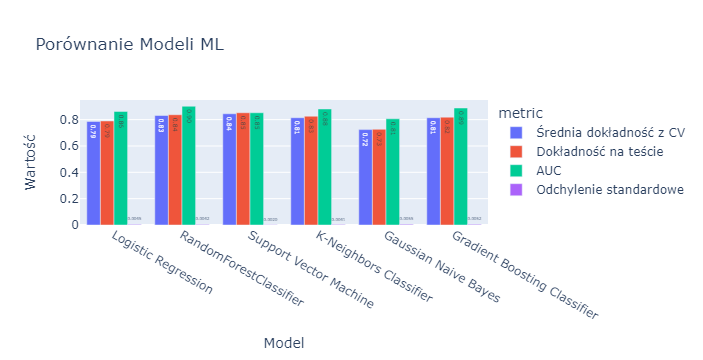

In [230]:
# Convert dataframe to long format
df_long = df.melt(id_vars=['model'], value_vars=['average_cv_score', 'accuracy_test', 'auc', 'std_dev'],
                               var_name='metric', value_name='value')

# Mapping Polish names of metrics
metric_mapping = {
    'average_cv_score': 'Średnia dokładność z CV',
    'std_dev': 'Odchylenie standardowe',
    'accuracy_test': 'Dokładność na teście',
    'auc': 'AUC'
}

df_long['metric'] = df_long['metric'].map(metric_mapping)

# Add labels to the top of bars with custom formatting
df_long['text'] = df_long.apply(lambda x: f'{x["value"]:.4f}' if x['metric'] == 'Odchylenie standardowe' else f'{x["value"]:.2f}', axis=1)

# Create the bar chart
fig = px.bar(df_long, x='model', y='value', color='metric',
             title='Porównanie Modeli ML',
             labels={'value': 'Wartość', 'variable': 'Metryka', 'model': 'Model'},
             barmode='group',
             text='text')

# Display the chart
fig.show()

#### Conclusions

1. Average Cross-Validation Score:

* Support Vector Machine (SVM) exhibits the highest average cross-validation score, indicating a robust performance during training across different subsets of the dataset.
* Random Forest Classifier follows closely, showing competitive performance in cross-validation.

2. Standard Deviation:

* Support Vector Machine (SVM) has the lowest standard deviation, implying consistent and stable performance during cross-validation.
* Gaussian Naive Bayes demonstrates the highest standard deviation, suggesting more variability in its performance across different folds.

3. Accuracy on Test Set:

* Support Vector Machine (SVM) achieves the highest accuracy on the test set, indicating its effectiveness in generalizing to unseen data.
* Random Forest Classifier also performs well, closely following SVM in test set accuracy.

4. Area Under the ROC Curve (AUC):

* Random Forest Classifier and Support Vector Machine (SVM) lead in AUC, showcasing their ability to discriminate between positive and negative instances effectively.
* Gaussian Naive Bayes lags slightly behind in AUC, suggesting room for improvement in its discriminatory power.

Overall Insights:

* Support Vector Machine (SVM) emerges as a strong performer across multiple metrics, demonstrating high accuracy, stability in cross-validation, and a competitive AUC.
* Random Forest Classifier also performs well, particularly excelling in AUC, although it comes with a trade-off of longer training times.
* Gaussian Naive Bayes exhibits a lower average performance across metrics, especially in AUC, indicating potential limitations in discriminatory power.


### 5.2.2 Chart model comparison: Confusion Matrix Analysiss

The graph shows a comparison of confusion matrix analysis for different machine learning models. Each model is represented by four bars, each representing one of the four values ​​in the confusion matrix: 'Correct Positive,' 'Correct Negative,' 'False Positive,' and 'False Negative.' The labels at the top of each bar show the exact numbers for each of these values.


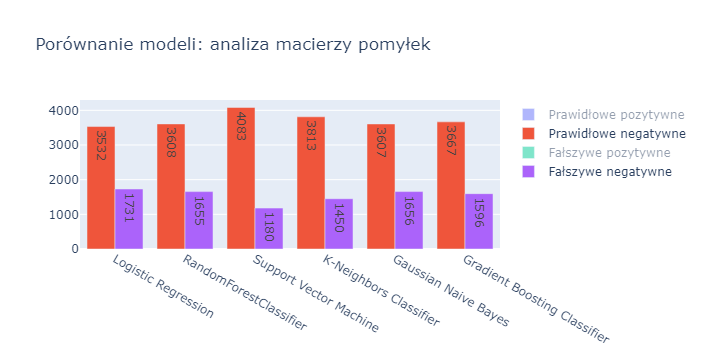

In [229]:
# Preparing data
models = ["Logistic Regression", "RandomForestClassifier", "Support Vector Machine", "K-Neighbors Classifier", "Gaussian Naive Bayes", "Gradient Boosting Classifier"]

tp_values = df_cm_data["Prawidłowe pozytywne"].tolist()
tn_values = df_cm_data["Prawidłowe negatywne"].tolist()
fp_values = df_cm_data["Fałszywe pozytywne"].tolist()
fn_values = df_cm_data["Fałszywe negatywne"].tolist()

# Create charts
fig1 = go.Figure()

fig1.add_bar(x=models, y=tp_values, name="Prawidłowe pozytywne", text=tp_values, textposition="auto")
fig1.add_bar(x=models, y=tn_values, name="Prawidłowe negatywne", text=tn_values, textposition="auto")
fig1.add_bar(x=models, y=fp_values, name="Fałszywe pozytywne", text=fp_values, textposition="auto")
fig1.add_bar(x=models, y=fn_values, name="Fałszywe negatywne", text=fn_values, textposition="auto")

fig1.update_layout(title="Porównanie modeli: analiza macierzy pomyłek", barmode="group")

# View charts
fig1.show()

**Conclusions**

1. True Positives: The number of correctly classified positive instances. It is evident that the Random Forest Classifier, Support Vector Machine, and Gradient Boosting Classifier models achieved the highest values, which is crucial since the primary goal is accurate recognition of problematic content.


2. True Negatives: The number of correctly classified negative instances. In this case, the Random Forest Classifier, Support Vector Machine, and Gradient Boosting Classifier models also achieved high results.


3. False Positives: The number of instances incorrectly classified as positive. Logistic Regression and Gaussian Naive Bayes show a tendency for false positives, which can be critical in the context of classifying problematic content.


4. False Negatives: The number of instances incorrectly classified as negative. For this case, the K-Neighbors Classifier seems to be the most susceptible to errors, suggesting that it may struggle with identifying certain problematic content.


Confusion matrix analysis is a significant tool in evaluating the effectiveness of classification models, especially in the context of classifying positive instances. For this specific task, the Random Forest Classifier, Support Vector Machine, and Gradient Boosting Classifier models appear to be the most promising, achieving high values in key categories.
del selection.

### 5.2.3 Chart training time disparity across ML Models

The bar chart compares the training times of various machine learning models. Each bar represents a different model, showcasing the minutes required for model training.

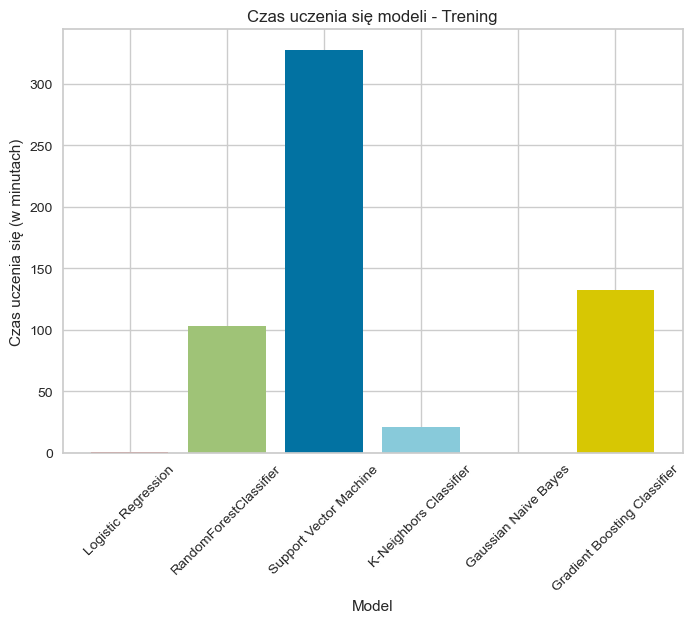

In [253]:
# Convert learning time to minutes
df['prediction_time_train_minutes'] = df['prediction_time_train'] / 60

# Colors for models
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Select columns
model = df['model']
prediction_time_train_minutes = df['prediction_time_train_minutes']

# Create a chart
plt.bar(model, prediction_time_train_minutes, color=colors)
plt.xlabel('Model')
plt.ylabel('Czas uczenia się (w minutach)')
plt.title('Czas uczenia się modeli - Trening')
plt.xticks(rotation=45)

# Display chart
plt.show()

The bar chart visualizes the training time (in minutes) for different machine learning models. Each bar represents a specific model, and the height of the bar indicates the corresponding training time.

**Observations**:

* Significant Disparity in Training Times: There is a notable discrepancy in the training times across different models.

* Random Forest Classifier and Support Vector Machine stand out with significantly longer training times compared to other models. This is particularly evident in the forest green and dark blue bars.

* Logistic Regression and Gaussian Naive Bayes exhibit remarkably shorter training times. The light red and light blue bars indicate that these models are computationally efficient during the training phase.

* Importance of Efficiency: The chart underscores the importance of computational efficiency, especially in scenarios where quick model training is crucial.

### 5.2.4 Chart Comparison of Model training times on test data

This chart illustrates the variation in prediction times among different machine learning models during the testing phase. Each bar represents a specific model, showcasing the time required for predictions on the test set. The diverse colors aid in easy model identification. Insights from the chart can guide decisions regarding model selection, particularly when balancing the need for accurate predictions with computational efficiency. The trade-off between prediction time and model complexity becomes apparent, influencing considerations for deployment in real-world applications.

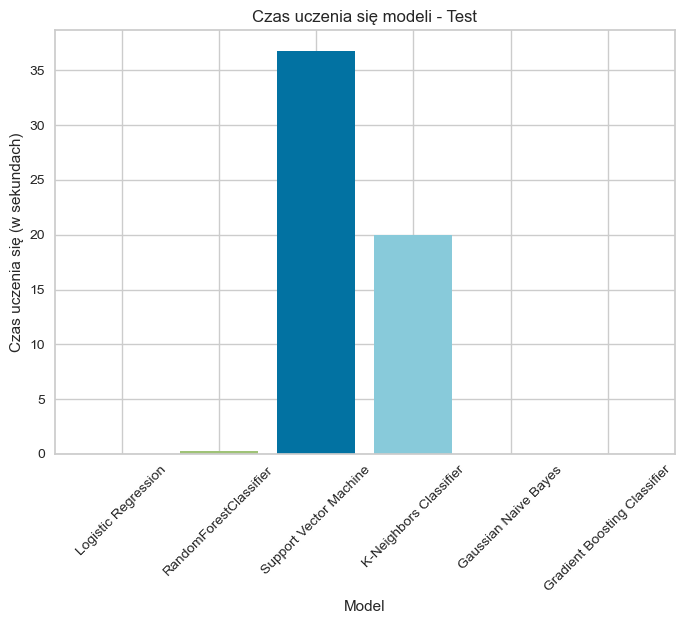

In [16]:
# Select columns
model = df['model']
prediction_time_train = df['prediction_time_test']

# Colors for models
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Create a chart
plt.bar(model, prediction_time_train, color=colors)
plt.xlabel('Model')
plt.ylabel('Czas uczenia się (w sekundach)')
plt.title('Czas uczenia się modeli - Test')
plt.xticks(rotation=45)

# Display chart
plt.show()

The bar chart visualizes the training time (in minutes) for different machine learning models. Each bar represents a specific model, and the height of the bar indicates the corresponding training time.

**Observations**:
* 
Significant Disparity in Training Times: There is a notable discrepancy in the training times across different models.* ne: Random Forest Classifier and Support Vector Machine stand out with significantly longer training times compared to other models. This is particularly evident in the forest green and dark blue bar* ayes: Logistic Regression and Gaussian Naive Bayes exhibit remarkably shorter training times. The light red and light blue bars indicate that these models are computationally efficient during the training ph* ase.

Importance of Efficiency: The chart underscores the importance of computational efficiency, especially in scenarios where quick model training is crucial.

**Conclusions**

1. Significant Variation in Training Time:

* Support Vector Machine (SVM): Exhibits the longest prediction time, exceeding 36 seconds. This indicates that SVM is computationally intensive during the testing phase.
Random Forest Classifier and Gradient Boosting Classifier: Demonstrate moderate training times compared to SVM, with the Random Forest Classifier being slightly faster.

2. Efficient Models:

* Logistic Regression, K-Neighbors Classifier, Gaussian Naive Bayes: Display notably shorter prediction times, measured in seconds. Among them, Logistic Regression stands out as the most efficient model in terms of prediction time.
  
3. Consideration for Deployment:

* When deployment and real-time predictions are critical, models such as Logistic Regression, K-Neighbors Classifier, and Gaussian Naive Bayes might be more suitable due to their lower prediction times.
* For applications where slightly longer prediction times are acceptable, and model complexity is beneficial, Random Forest Classifier and Gradient Boosting Classifier could be considered.
Trade-off between Time and Model Complexity:

The chart highlights the trade-off between model complexity and prediction time. More complex models like Support Vector Machine tend to require more time for predictions, whereas simpler models like Logistic Regression can provide faster results.
Understanding the trade-offs between prediction time and model performance is crucial for selecting the most suitable model based on specific application requirements. In scenarios where timely predictions are paramount, opting for models with lower prediction times, such as Logistic Regression, becomes essential.


## 5.3 Summary

In the realm of customer support and communication, effectively addressing negative sentiments expressed by customers is crucial. This project focuses on the classification of emails, with a specific emphasis on accurately identifying messages with negative content (1). The models are evaluated based on several key metrics, including cross-validation scores, accuracy on the test set, prediction times, area under the ROC curve (AUC), and confusion matrices.

**Top Three Models**:

1. Logistic Regression:
* Average CV Score: 0.786
* Standard Deviation: 0.0045
* Accuracy on Test Set: 0.790
* Prediction Time (Train): 27.67 seconds
* Prediction Time (Test): 0.001 seconds
* AUC: 0.862
* Confusion Matrix: [[6577, 960], [1731, 3532]]

2. Random Forest Classifier:
* Average CV Score: 0.831
* Standard Deviation: 0.0042
* Accuracy on Test Set: 0.837
* Prediction Time (Train): 6193.58 seconds
* Prediction Time (Test): 0.31 seconds
* AUC: 0.902
* Confusion Matrix: [[7108, 429], [1655, 3608]]

3. Support Vector Machine:
* Average CV Score: 0.844
* Standard Deviation: 0.002
* Accuracy on Test Set: 0.852
* Prediction Time (Train): 19674.85 seconds
* Prediction Time (Test): 36.81 seconds
* AUC: 0.852
* Confusion Matrix: [[6825, 712], [1180, 4083]]

**Comparison and Insights**:

* Logistic Regression showcases a balanced performance, emphasizing efficiency with quick prediction times.

* Random Forest Classifier excels in accuracy and AUC, albeit at the cost of longer training times.

* Support Vector Machine demonstrates competitive accuracy and balanced prediction times, making it a versatile choice for this task.

**Best Model for Negative Email Classification**:

Considering the emphasis on correctly classifying negative emails (1), the **Support Vector Machine** emerges as the most suitable model. It strikes a balance betwcrucial for identifying customer problemsrucial for timely customer issue resolution.

**Alternatives and Their Advantages**:

* Random Forest Classifier: Provides higher accuracy but demands more computational resources during training. Suitable when prioritizing accuracy over efficiency.

* Logistic Regression: Offers a quick and efficient solution, ideal for scenarios where computational resources are limited, and a slightly lower accuracy is acceptable.

In conclusion, the **Support Vector Machine** is recommended for effectively classifying negative emails, with alternatives available based on specific priorities and resource constraints.ed on specific priorities and resource constraints.